In [1]:
import torch, torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np

# -----------------------------------
# Config
# -----------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 256
num_workers = 4
backbone_name = "resnet18"   # or "mobilenet_v3_small"
save_npz = True
out_path = "cifar10_resnet18_embeddings.npz"

# -----------------------------------
# Build model + transforms
# -----------------------------------
def get_backbone(name="resnet18"):
    name = name.lower()
    if name == "resnet18":
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        m = models.resnet18(weights=weights)
        dim, img_size = 512, 224
        backbone = nn.Sequential(*(list(m.children())[:-1]))
    elif name == "mobilenet_v3_small":
        weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        m = models.mobilenet_v3_small(weights=weights)
        dim, img_size = 576, 224
        backbone = nn.Sequential(m.features, m.avgpool)
    else:
        raise ValueError("use 'resnet18' or 'mobilenet_v3_small'")
    for p in backbone.parameters(): p.requires_grad = False
    backbone.eval()
    return backbone.to(device), dim, img_size

def build_transforms(img_size=224):
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

# -----------------------------------
# Extract embeddings
# -----------------------------------
@torch.no_grad()
def extract_embeddings(backbone, loader, dim):
    N = len(loader.dataset)
    X = np.zeros((N, dim), dtype=np.float32)
    y = np.zeros((N,), dtype=np.int64)
    idx = 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        feats = backbone(imgs).view(imgs.size(0), -1).cpu().numpy()
        b = feats.shape[0]
        X[idx:idx+b] = feats
        y[idx:idx+b] = labels.numpy()
        idx += b
    return X, y

# -----------------------------------
# Run everything
# -----------------------------------
backbone, embed_dim, img_size = get_backbone(backbone_name)
tfm = build_transforms(img_size)

train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
test_set  = datasets.CIFAR10(root="./data", train=False, download=True, transform=tfm)
classes = np.array(train_set.classes, dtype=object)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Extracting {embed_dim}-d embeddings on {device}...")
X_train, y_train = extract_embeddings(backbone, train_loader, embed_dim)
X_test,  y_test  = extract_embeddings(backbone, test_loader,  embed_dim)
print("Done ✅")

# Save if desired
if save_npz:
    np.savez_compressed(
        out_path,
        embeddings_train=X_train, labels_train=y_train,
        embeddings_test=X_test,  labels_test=y_test,
        classes=classes,
        model_name=np.array(backbone_name),
        embed_dim=np.array(embed_dim),
        dataset=np.array("cifar10"),
        note=np.array("Imagenet-pretrained backbone; features are penultimate activations.")
    )
    print(f"Saved → {out_path}")

# You can now use X_train, y_train, X_test, y_test directly:
print("train:", X_train.shape, "test:", X_test.shape)


100%|████████████████████████████████████████| 170M/170M [00:02<00:00, 61.1MB/s]


Extracting 512-d embeddings on cpu...
Done ✅
Saved → cifar10_resnet18_embeddings.npz
train: (50000, 512) test: (10000, 512)


In [2]:
# =========================================================
# CIFAR-10 ResNet Embeddings → Progressive VAE + Classifier + Conditional Diffusion
# =========================================================
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os

# ------------------ Config ------------------
npz_path   = "cifar10_resnet18_embeddings.npz"
save_path  = "joint_diffusion_vae_best.pt"
seed       = 1337
batch_size = 256
epochs     = 250
latent_dim = 64
T          = 2500
beta_sched = "cosine"
# beta_sched = "linear"
lr         = 1e-4
λ_cls      = 1.0
λ_diff     = 1.0
kl_weight  = 1e-6
weight_decay = 1e-8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed); np.random.seed(seed)

# ------------------ Data ------------------
dat = np.load(npz_path, allow_pickle=True)
Xtr, ytr = dat["embeddings_train"], dat["labels_train"]
classes  = dat["classes"].tolist() if "classes" in dat else [str(i) for i in range(10)]
num_classes, embed_dim = len(classes), Xtr.shape[1]
print(f"[info] embedding dim = {embed_dim}")

# Standardize embeddings
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr.astype(np.float32))
np.savez("embedding_scaler_stats.npz", mean=scaler.mean_, scale=scaler.scale_)

class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

loader = DataLoader(EmbeddingDataset(Xtr, ytr),
                    batch_size=batch_size, shuffle=True, drop_last=True)

# ------------------ Progressive VAE ------------------
class ProgressiveVAE(nn.Module):
    def __init__(self, input_dim=512, latent_dim=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
        )
        self.mu     = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)
    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z): return self.dec(z)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        x_rec = self.decode(z)
        return x_rec, mu, logvar, z

# ------------------ Classifier ------------------
class Classifier(nn.Module):
    def __init__(self, z_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128), nn.ReLU(),
            nn.Linear(128, num_classes))
    def forward(self, z): return self.net(z)

# ------------------ Diffusion ------------------
class FourierFeatures(nn.Module):
    def __init__(self, T, num_freqs=8):
        super().__init__()
        self.T = T
        freqs = 2**torch.arange(num_freqs).float()*math.pi
        self.register_buffer("freqs_buf", freqs)
    def forward(self, t):
        x = (t.float().unsqueeze(-1)/self.T)*self.freqs_buf
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim), nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim))
        self.act = nn.GELU()
    def forward(self,x): return self.act(x+self.net(x))

class ConditionalDenoiser(nn.Module):
    def __init__(self, z_dim, num_classes, T,
                 y_embed_dim=64, time_embed_dim=64,
                 width=128, depth=3, num_freqs=8, dropout=0.1):
        super().__init__()
        self.ff = FourierFeatures(T,num_freqs)
        self.t_mlp = nn.Sequential(
            nn.Linear(2*num_freqs,time_embed_dim),nn.GELU(),
            nn.Linear(time_embed_dim,time_embed_dim))
        self.y_emb = nn.Embedding(num_classes,y_embed_dim)
        self.inp = nn.Linear(z_dim + time_embed_dim + y_embed_dim, width)
        self.blocks = nn.ModuleList([ResidualBlock(width,dropout) for _ in range(depth)])
        self.out = nn.Sequential(nn.LayerNorm(width), nn.Linear(width,z_dim))
    def forward(self, zt,t,y):
        t_emb = self.t_mlp(self.ff(t))
        y_emb = self.y_emb(y)
        h = torch.cat([zt,t_emb,y_emb],dim=1)
        h = self.inp(h)
        for blk in self.blocks: h = blk(h)
        return self.out(h)


def make_beta_schedule(T=T, kind="cosine"):
    if kind == "cosine":
        s = 0.008
        t = torch.linspace(0, T, T+1, dtype=torch.float32) / T
        alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi / 2) ** 2
        # ✅ fix: avoid in-place op on a view
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0].clone()
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 1e-5, .1)
    else:
        return torch.linspace(1e-4, 0.06, T)



class Diffusion:
    def __init__(self, T=T, schedule="cosine", device="cpu"):
        self.T, self.device = T, device
        self.betas = make_beta_schedule(T, schedule).to(device)
        self.alphas = 1. - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
    def q_sample(self, x0, t):
        noise = torch.randn_like(x0)
        a_bar_t = self.alpha_bar[t].view(-1,1)
        xt = torch.sqrt(a_bar_t)*x0 + torch.sqrt(1-a_bar_t)*noise
        return xt, noise

# ------------------ Instantiate ------------------
vae = ProgressiveVAE(embed_dim, latent_dim).to(device)
clf = Classifier(latent_dim, num_classes).to(device)
denoiser = ConditionalDenoiser(latent_dim, num_classes, T=T).to(device)
diff = Diffusion(T=T, schedule=beta_sched, device=device)

opt = torch.optim.AdamW(
    list(vae.parameters()) + list(clf.parameters()) + list(denoiser.parameters()),
    lr=lr, weight_decay=weight_decay)

# ------------------ Training ------------------
best_loss = float("inf")
os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)

for ep in range(1, epochs+1):
    vae.train(); clf.train(); denoiser.train()
    tot_vae, tot_cls, tot_diff = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # --- VAE ---
        x_rec, mu, logvar, z = vae(x)
        recon = F.mse_loss(x_rec, x)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        vae_loss = recon + kl_weight * kl

        # --- Classifier ---
        logits = clf(z.detach())
        cls_loss = F.cross_entropy(logits, y)

        # --- Diffusion ---
        t = torch.randint(0, T, (x.size(0),), device=device)
        zt, noise = diff.q_sample(z.detach(), t)
        pred = denoiser(zt, t, y)
        diff_loss = F.mse_loss(pred, noise)

        # --- Total ---
        loss = vae_loss + λ_cls*cls_loss + λ_diff*diff_loss
        opt.zero_grad(); loss.backward(); opt.step()

        tot_vae += vae_loss.item() * x.size(0)
        tot_cls += cls_loss.item() * x.size(0)
        tot_diff += diff_loss.item() * x.size(0)

    n = len(loader.dataset)
    vae_loss_epoch  = tot_vae / n
    cls_loss_epoch  = tot_cls / n
    diff_loss_epoch = tot_diff / n
    total_loss_epoch = vae_loss_epoch + λ_cls*cls_loss_epoch + λ_diff*diff_loss_epoch

    if total_loss_epoch < best_loss:
        best_loss = total_loss_epoch
        torch.save({
            "vae": vae.state_dict(),
            "clf": clf.state_dict(),
            "denoiser": denoiser.state_dict(),
            "epoch": ep,
            "loss": best_loss,
        }, save_path)
        print(f"✅ [Ep {ep:03d}] Saved best model | total_loss={best_loss:.4f}")

    print(f"[Ep {ep:03d}] VAE={vae_loss_epoch:.4f} CLS={cls_loss_epoch:.4f} "
          f"DIFF={diff_loss_epoch:.4f} TOTAL={total_loss_epoch:.4f} (best={best_loss:.4f})")

print(f"\nTraining complete. Best model saved to: {save_path}")





[info] embedding dim = 512
✅ [Ep 001] Saved best model | total_loss=3.9627
[Ep 001] VAE=0.9382 CLS=1.9910 DIFF=1.0335 TOTAL=3.9627 (best=3.9627)
✅ [Ep 002] Saved best model | total_loss=2.5021
[Ep 002] VAE=0.7432 CLS=0.9950 DIFF=0.7640 TOTAL=2.5021 (best=2.5021)
✅ [Ep 003] Saved best model | total_loss=2.0027
[Ep 003] VAE=0.6447 CLS=0.7452 DIFF=0.6129 TOTAL=2.0027 (best=2.0027)
✅ [Ep 004] Saved best model | total_loss=1.8002
[Ep 004] VAE=0.5907 CLS=0.6572 DIFF=0.5523 TOTAL=1.8002 (best=1.8002)
✅ [Ep 005] Saved best model | total_loss=1.6990
[Ep 005] VAE=0.5554 CLS=0.6041 DIFF=0.5396 TOTAL=1.6990 (best=1.6990)
✅ [Ep 006] Saved best model | total_loss=1.6534
[Ep 006] VAE=0.5277 CLS=0.5733 DIFF=0.5524 TOTAL=1.6534 (best=1.6534)
✅ [Ep 007] Saved best model | total_loss=1.6251
[Ep 007] VAE=0.5061 CLS=0.5526 DIFF=0.5664 TOTAL=1.6251 (best=1.6251)
✅ [Ep 008] Saved best model | total_loss=1.6055
[Ep 008] VAE=0.4888 CLS=0.5363 DIFF=0.5804 TOTAL=1.6055 (best=1.6055)
✅ [Ep 009] Saved best model |

[info] Loaded standardized embeddings: (50000, 512)
[info] Loaded model successfully.


Sampling latent z: 100%|███████████████████| 1000/1000 [00:02<00:00, 424.69it/s]


[info] Generated standardized embeddings: (10000, 512)
UMAP(random_state=1337, verbose=True)
Thu Nov 20 17:05:12 2025 Construct fuzzy simplicial set
Thu Nov 20 17:05:12 2025 Finding Nearest Neighbors
Thu Nov 20 17:05:12 2025 Building RP forest with 17 trees
Thu Nov 20 17:05:14 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Thu Nov 20 17:05:18 2025 Finished Nearest Neighbor Search
Thu Nov 20 17:05:19 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Nov 20 17:05:40 2025 Finished embedding


/var/folders/tc/qjb0w1k122v4jzwncjlh51140000gp/T/ipykernel_88509/149971367.py:202: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap("tab20", 20)


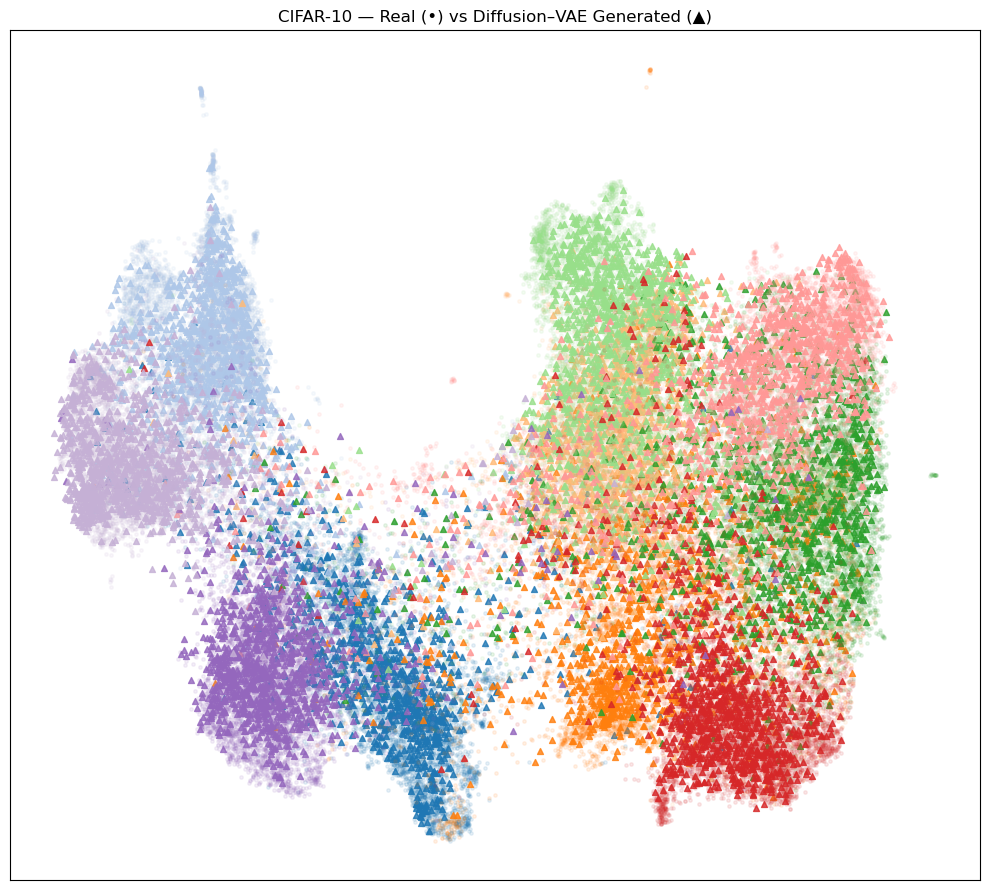

In [3]:
# =========================================================
# UMAP Visualization — Real vs Generated (Diffusion–VAE, Cosine β, Standardized)
# =========================================================
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import umap, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ------------------------------
# Paths & Settings
# ------------------------------
NPZ_PATH   = "cifar10_resnet18_embeddings.npz"
CKPT_PATH  = "joint_diffusion_vae_best.pt"
SCALER_PATH = "embedding_scaler_stats.npz"
seed       = 1337
latent_dim = 64
embed_dim  = 512
T_steps    = 1000
n_real_per_class = 1000
n_gen_per_class  = 1000
umap_neighbors   = 15
umap_min_dist    = 0.1
# kind = 'linear'
kind = 'cosine'
umap_metric      = "euclidean"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed); np.random.seed(seed)

# =========================================================
# Load Data & Standardize
# =========================================================
data = np.load(NPZ_PATH, allow_pickle=True)
Xtr, ytr = data["embeddings_train"], data["labels_train"]
classes  = data["classes"].tolist() if "classes" in data else [str(i) for i in range(10)]
num_classes = len(classes)

# Load saved scaler
stats = np.load(SCALER_PATH)
scaler = StandardScaler()
scaler.mean_, scaler.scale_ = stats["mean"], stats["scale"]
Xtr = scaler.transform(Xtr.astype(np.float32))

print(f"[info] Loaded standardized embeddings: {Xtr.shape}")

# =========================================================
# Model Definitions (exactly matches training)
# =========================================================
class ProgressiveVAE(nn.Module):
    def __init__(self, input_dim=512, latent_dim=64):
        super().__init__()
        # Encoder: 512 → 256 → 128 → (μ, logvar)
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
        )
        self.mu     = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        # Decoder: 64 → 128 → 256 → 512
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def encode(self, x): h=self.enc(x); return self.mu(h), self.logvar(h)
    def reparam(self, mu, logvar): return mu + torch.randn_like(mu)*torch.exp(0.5*logvar)
    def decode(self,z): return self.dec(z)

class FourierFeatures(nn.Module):
    def __init__(self, T, num_freqs=8):
        super().__init__()
        self.T = T
        freqs = 2**torch.arange(num_freqs).float()*math.pi
        # ✅ match training checkpoint buffer name
        self.register_buffer("freqs_buf", freqs)
    def forward(self,t):
        x = (t.float().unsqueeze(-1)/self.T)*self.freqs_buf
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim), nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim)
        )
        self.act = nn.GELU()
    def forward(self,x): return self.act(x + self.net(x))

class ConditionalDenoiser(nn.Module):
    def __init__(self, z_dim, num_classes, T=T,
                 y_embed_dim=64, time_embed_dim=64,
                 width=128, depth=3, num_freqs=8, dropout=0.1):
        super().__init__()
        self.ff = FourierFeatures(T, num_freqs)
        self.t_mlp = nn.Sequential(
            nn.Linear(2*num_freqs, time_embed_dim), nn.GELU(),
            nn.Linear(time_embed_dim, time_embed_dim))
        self.y_emb = nn.Embedding(num_classes, y_embed_dim)
        self.inp = nn.Linear(z_dim + time_embed_dim + y_embed_dim, width)
        self.blocks = nn.ModuleList([ResidualBlock(width, dropout) for _ in range(depth)])
        self.out = nn.Sequential(nn.LayerNorm(width), nn.Linear(width, z_dim))
    def forward(self, zt, t, y):
        t_emb = self.t_mlp(self.ff(t))
        y_emb = self.y_emb(y)
        h = torch.cat([zt, t_emb, y_emb], dim=1)
        h = self.inp(h)
        for blk in self.blocks: h = blk(h)
        return self.out(h)

def make_beta_schedule(T=T, kind="cosine"):
    if kind == "cosine":
        s = 0.008
        t = torch.linspace(0, T, T+1, dtype=torch.float32) / T
        alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi / 2) ** 2
        # ✅ fix: avoid in-place op on a view
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0].clone()
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 1e-5, .1)
    else:
        return torch.linspace(1e-4, 0.02, T)

class Diffusion:
    def __init__(self, T=T, device="cpu"):
        self.T, self.device = T, device
        self.betas = make_beta_schedule(T, kind).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
    @torch.no_grad()
    def p_sample_loop(self, denoiser, y, D):
        """DDPM ancestral sampling"""
        x = torch.randn(y.size(0), D, device=self.device)
        for t in tqdm(reversed(range(self.T)), total=self.T, desc="Sampling latent z"):
            tT = torch.full((y.size(0),), t, device=self.device, dtype=torch.long)
            eps = denoiser(x, tT, y)
            beta_t = self.betas[t]
            alpha_t = self.alphas[t]
            alpha_bar_t = self.alpha_bar[t]
            mean = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * eps)
            if t > 0:
                noise = torch.randn_like(x)
                x = mean + torch.sqrt(beta_t) * noise
            else:
                x = mean
        return x

# =========================================================
# Load Trained Model
# =========================================================
vae = ProgressiveVAE(embed_dim, latent_dim).to(device)
denoiser = ConditionalDenoiser(latent_dim, num_classes, T=T_steps).to(device)
checkpoint = torch.load(CKPT_PATH, map_location=device)
vae.load_state_dict(checkpoint["vae"])
denoiser.load_state_dict(checkpoint["denoiser"])
vae.eval(); denoiser.eval()
diff = Diffusion(T=T_steps, device=device)
print("[info] Loaded model successfully.")

# =========================================================
# Generate Samples per Class
# =========================================================
gen_list, gen_labels = [], []
with torch.no_grad():
    for cid in range(num_classes):
        y_batch = torch.full((n_gen_per_class,), cid, dtype=torch.long, device=device)
        z_gen = diff.p_sample_loop(denoiser, y_batch, D=latent_dim)
        Xg = vae.decode(z_gen).cpu().numpy()
        gen_list.append(Xg)
        gen_labels.append(np.full((n_gen_per_class,), cid, dtype=np.int64))

X_gen = np.concatenate(gen_list, axis=0)
y_gen = np.concatenate(gen_labels, axis=0)
print(f"[info] Generated standardized embeddings: {X_gen.shape}")

# =========================================================
# Combine + Inverse Standardize for UMAP
# =========================================================
X_real_unscaled = scaler.inverse_transform(Xtr)
X_gen_unscaled  = scaler.inverse_transform(X_gen)
X_all = np.concatenate([X_real_unscaled, X_gen_unscaled], axis=0)
y_all = np.concatenate([ytr, y_gen], axis=0)
domain = np.concatenate([np.zeros(len(X_real_unscaled)), np.ones(len(X_gen_unscaled))], axis=0)

# =========================================================
# UMAP Projection
# =========================================================
reducer = umap.UMAP(
    n_neighbors=umap_neighbors,
    min_dist=umap_min_dist,
    metric=umap_metric,
    random_state=seed,
    n_components=2,
    verbose=True,
)
Z2 = reducer.fit_transform(X_all)

# =========================================================
# Plot Real (•) vs Generated (▲)
# =========================================================
def color_map_for_classes(n_classes):
    base = plt.cm.get_cmap("tab20", 20)
    return np.array([base(i % 20) for i in range(n_classes)])

colors = color_map_for_classes(num_classes)
plt.figure(figsize=(10, 9))
for c in range(num_classes):
    m_real = (y_all == c) & (domain == 0)
    m_gen  = (y_all == c) & (domain == 1)
    plt.scatter(Z2[m_real, 0], Z2[m_real, 1], s=6, alpha=0.1, color=colors[c])
    plt.scatter(Z2[m_gen, 0],  Z2[m_gen, 1],  s=18, alpha=0.8, color=colors[c], marker="^")
plt.title("CIFAR-10 — Real (•) vs Diffusion–VAE Generated (▲)")
plt.xticks([]); plt.yticks([]); plt.tight_layout()
plt.show()


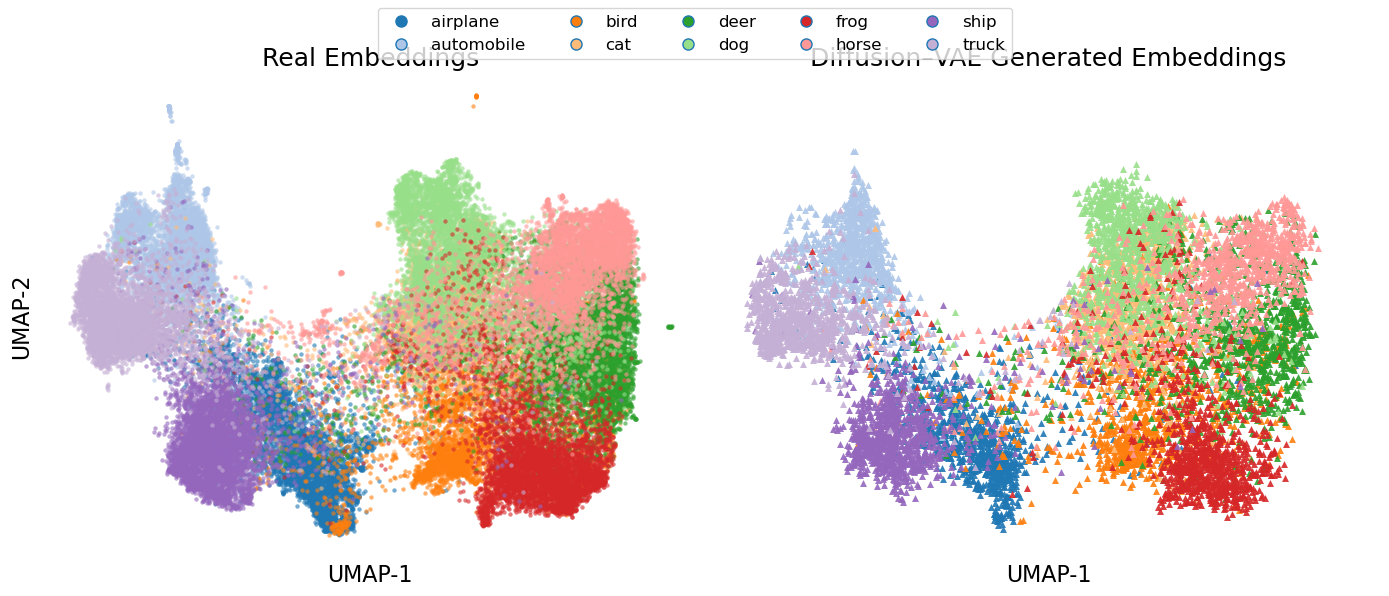

✅ Saved full vector SVG: umap_real_vs_generated_fullvector.svg


In [4]:
# =========================================================
# UMAP Visualization — Real vs Generated (Full SVG, All Points Vector)
# =========================================================
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# --- Colormap Utility ---
def color_map_for_classes(n_classes):
    base = mpl.colormaps["tab20"]
    return np.array([base(i % 20) for i in range(n_classes)])

colors = color_map_for_classes(num_classes)

is_real = (domain == 0)
is_gen  = (domain == 1)

# --- Create figure ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
titles = ["Real Embeddings", "Diffusion–VAE Generated Embeddings"]

for ax, mask, title in zip(axes, [is_real, is_gen], titles):
    for c in range(num_classes):
        m = (y_all == c) & mask
        ax.scatter(
            Z2[m, 0], Z2[m, 1],
            s=10 if mask is is_real else 25,
            alpha=0.6 if mask is is_real else 0.9,
            color=colors[c],
            marker='o' if mask is is_real else '^',
            linewidths=0.0,           # prevent outlines
            rasterized=False          # 🔥 ensure SVG vectors
        )
    ax.set_title(title, fontsize=18)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("UMAP-1", fontsize=16)
    if ax == axes[0]:
        ax.set_ylabel("UMAP-2", fontsize=16)
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

# --- Legend ---
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        linestyle='none',
        markerfacecolor=colors[c],
        label=classes[c],
        markersize=8
    )
    for c in range(num_classes)
]
fig.legend(handles=handles, loc='upper center', ncol=num_classes//2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# --- 🔥 FULL VECTOR SVG OUTPUT ---
plt.savefig(
    "umap_real_vs_generated_fullvector.svg",
    format="svg",
    bbox_inches="tight"
)

plt.show()

print("✅ Saved full vector SVG: umap_real_vs_generated_fullvector.svg")


[info] Loaded standardized test embeddings: (10000, 512)
[info] Model loaded successfully.


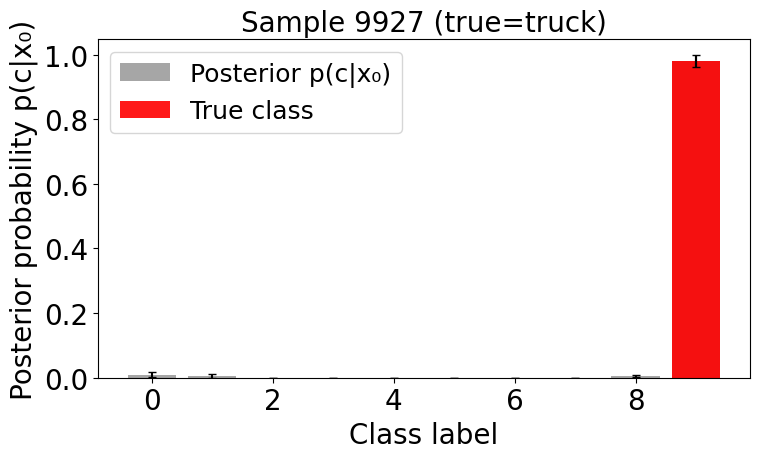

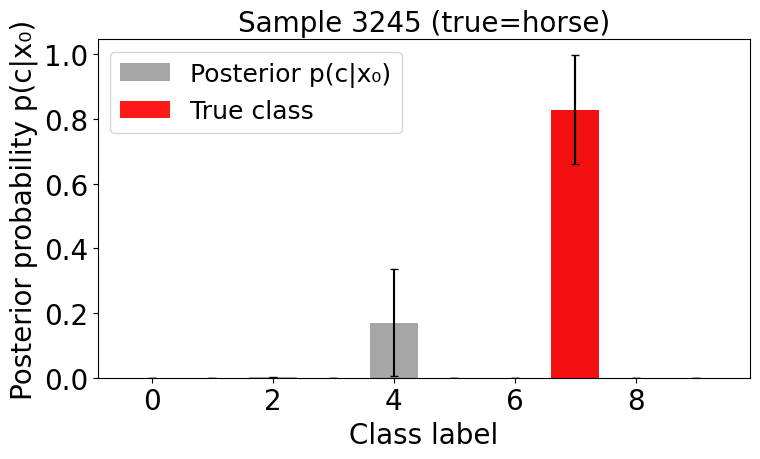

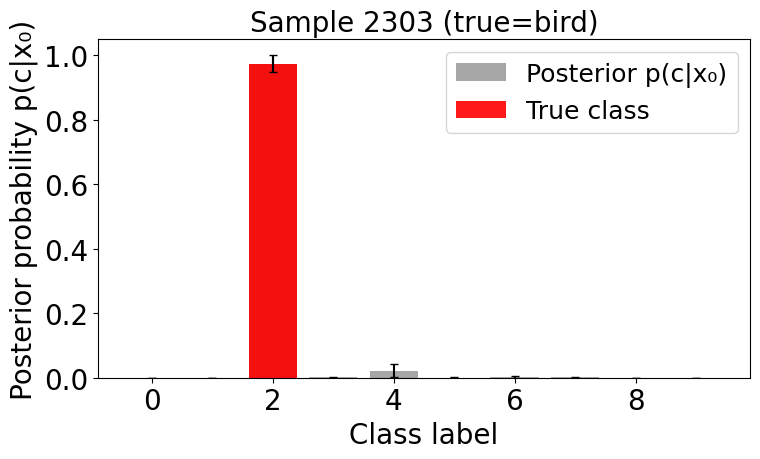

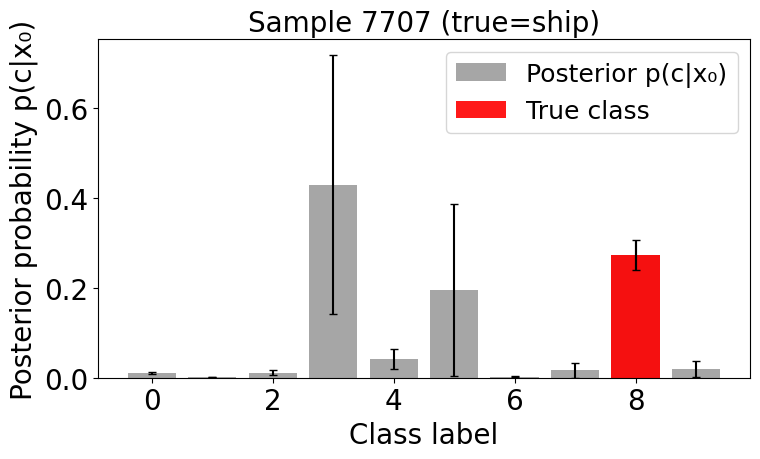

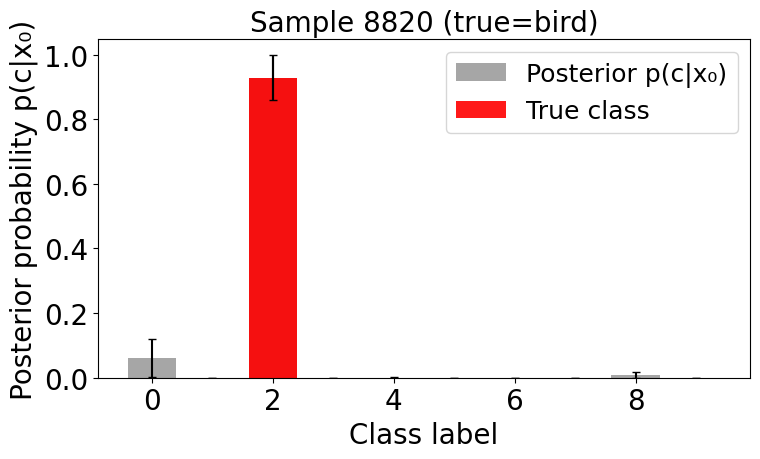

In [6]:
# =========================================================
# Diffusion–VAE Posterior Inference with Softmax Averaging
# =========================================================
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ------------------------------
# Paths & Parameters
# ------------------------------
NPZ_PATH   = "cifar10_resnet18_embeddings.npz"
CKPT_PATH  = "joint_diffusion_vae_best.pt"
SCALER_PATH = "embedding_scaler_stats.npz"
seed        = 1337
latent_dim  = 64
embed_dim   = 512
T_train     = T
T_eval      = T
n_paths     = 2
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed); np.random.seed(seed)

# =========================================================
# Load standardized test embeddings
# =========================================================
data = np.load(NPZ_PATH, allow_pickle=True)
Xtest, ytest = data["embeddings_test"], data["labels_test"]
classes = data["classes"].tolist() if "classes" in data else [str(i) for i in range(10)]
num_classes = len(classes)

# Standardize
stats = np.load(SCALER_PATH)
scaler = StandardScaler()
scaler.mean_, scaler.scale_ = stats["mean"], stats["scale"]
Xtest = scaler.transform(Xtest.astype(np.float32))
print(f"[info] Loaded standardized test embeddings: {Xtest.shape}")

# =========================================================
# Model definitions (identical to training)
# =========================================================
class ProgressiveVAE(nn.Module):
    def __init__(self, input_dim=512, latent_dim=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
        )
        self.mu, self.logvar = nn.Linear(128, latent_dim), nn.Linear(128, latent_dim)
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def encode(self, x): h=self.enc(x); return self.mu(h), self.logvar(h)
    def reparam(self, mu, logvar): return mu + torch.randn_like(mu)*torch.exp(0.5*logvar)
    def decode(self, z): return self.dec(z)

class FourierFeatures(nn.Module):
    def __init__(self, T, num_freqs=8):
        super().__init__()
        self.T = T
        freqs = 2**torch.arange(num_freqs).float()*math.pi
        self.register_buffer("freqs_buf", freqs)
    def forward(self, t):
        x = (t.float().unsqueeze(-1)/self.T)*self.freqs_buf
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(dim, dim)
        )
    def forward(self, x): return x + self.net(x)

class ConditionalDenoiser(nn.Module):
    def __init__(self, z_dim, num_classes, T, num_freqs=8, width=128, depth=3):
        super().__init__()
        self.ff = FourierFeatures(T, num_freqs)
        self.t_mlp = nn.Sequential(
            nn.Linear(2*num_freqs, 64), nn.GELU(), nn.Linear(64, 64))
        self.y_emb = nn.Embedding(num_classes, 64)
        self.inp = nn.Linear(z_dim + 128, width)
        self.blocks = nn.ModuleList([ResidualBlock(width) for _ in range(depth)])
        self.out = nn.Sequential(nn.LayerNorm(width), nn.Linear(width, z_dim))
    def forward(self, zt, t, y):
        t_emb = self.t_mlp(self.ff(t)); y_emb = self.y_emb(y)
        h = torch.cat([zt, t_emb, y_emb], dim=1); h = self.inp(h)
        for blk in self.blocks: h = blk(h)
        return self.out(h)



# =========================================================
# Load trained model
# =========================================================
vae = ProgressiveVAE(embed_dim, latent_dim).to(device)
denoiser = ConditionalDenoiser(latent_dim, num_classes, T_train).to(device)
ckpt = torch.load(CKPT_PATH, map_location=device)
vae.load_state_dict(ckpt["vae"])
denoiser.load_state_dict(ckpt["denoiser"])
vae.eval(); denoiser.eval()
betas = make_beta_schedule(T_train, kind).to(device)
print("[info] Model loaded successfully.")

# =========================================================
# Diffusion posterior estimator with softmax averaging
# =========================================================
def diffusion_posterior(z0_obs, denoiser, betas, T_train, y_classes,
                        n_paths=4, T_eval=T, device=None):
    """
    Computes p(c|z0) ≈ E_eps[ softmax(L_c(eps)) ]
    Returns mean and SEM across noise paths.
    """
    if device is None: device = z0_obs.device
    B, D = z0_obs.shape
    C = len(y_classes)
    step_ids = np.linspace(1, T_train, T_eval, dtype=int)
    betas_sub = betas[step_ids - 1]
    alphas = 1. - betas_sub

    half = n_paths // 2
    eps_base = torch.randn(B, half, len(step_ids), D, device=device)
    eps = torch.cat([eps_base, -eps_base], dim=1)  # [B, n_paths, T_eval, D]

    L_all = torch.zeros(B, n_paths, C, device=device)

    for cidx, c in enumerate(y_classes):
        y = torch.full((B,), int(c), device=device, dtype=torch.long)
        zt = z0_obs.unsqueeze(1).repeat(1, n_paths, 1)
        y_expand = y.unsqueeze(1).repeat(1, n_paths)
        ll_acc = torch.zeros(B, n_paths, device=device)

        for i, t_idx in enumerate(step_ids):
            beta_t = betas[t_idx - 1]
            noise = eps[:, :, i, :]
            zt1 = torch.sqrt(alphas[i]) * zt + torch.sqrt(1 - alphas[i]) * noise
            dz = zt1 - zt
            y_flat = y_expand.reshape(B * n_paths)
            zt1_flat = zt1.reshape(B * n_paths, D)
            t_vec = torch.full((B * n_paths,), t_idx, dtype=torch.long, device=device)
            score = denoiser(zt1_flat, t_vec, y_flat)
            ll_i = (score * dz.reshape(B * n_paths, D)).sum(dim=1)
            ll_i += 0.5 * beta_t * (-(score ** 2).sum(dim=1)
                                    + (zt1_flat * score).sum(dim=1))
            ll_acc += ll_i.view(B, n_paths)
            zt = zt1.detach()

        L_all[:, :, cidx] = ll_acc

    # --- Softmax over classes per path, then average ---
    probs = torch.softmax(L_all, dim=2)      # [B, n_paths, C]
    mean_probs = probs.mean(1)               # [B, C]
    sem_probs = probs.std(1) / math.sqrt(n_paths)
    return mean_probs, sem_probs

# =========================================================
# Evaluate on test embeddings
# =========================================================
Xtest_t = torch.tensor(Xtest, dtype=torch.float32, device=device)
mu, logvar = vae.encode(Xtest_t)
ztest = mu  # use posterior mean for stability
y_classes = torch.arange(num_classes, device=device)

# =========================================================
# Visualize posterior for several samples
# =========================================================
N_vis = 5
idx_vis = np.random.choice(len(ztest), N_vis, replace=False)
for idx in idx_vis:
    z0 = ztest[idx:idx+1]
    true_c = int(ytest[idx])

    with torch.no_grad():
        mean_probs, sem_probs = diffusion_posterior(
            z0, denoiser, betas, T_train,
            y_classes, n_paths=n_paths, T_eval=T_eval, device=device
        )
    mean_probs = mean_probs.squeeze(0).cpu().numpy()
    sem_probs = sem_probs.squeeze(0).cpu().numpy()

    # Normalize
    mean_probs /= mean_probs.sum()

    # ---- Plot ----
    plt.figure(figsize=(8,5))
    plt.bar(np.arange(num_classes), mean_probs, yerr=sem_probs, capsize=3,
            color="gray", alpha=0.7, label="Posterior p(c|x₀)")
    plt.bar(true_c, mean_probs[true_c], yerr=sem_probs[true_c],
            color="red", alpha=0.9, label="True class")
    plt.xlabel("Class label")
    plt.ylabel("Posterior probability p(c|x₀)")
    plt.title(f"Sample {idx} (true={classes[true_c]})")
    plt.legend()
    plt.tight_layout()
    plt.show()


[info] Loaded standardized test embeddings: (10000, 512)
[info] Model loaded successfully.
[info] Selected indices per class: [1568, 1904, 8631, 2350, 1693, 4907, 6850, 3561, 8883, 686]


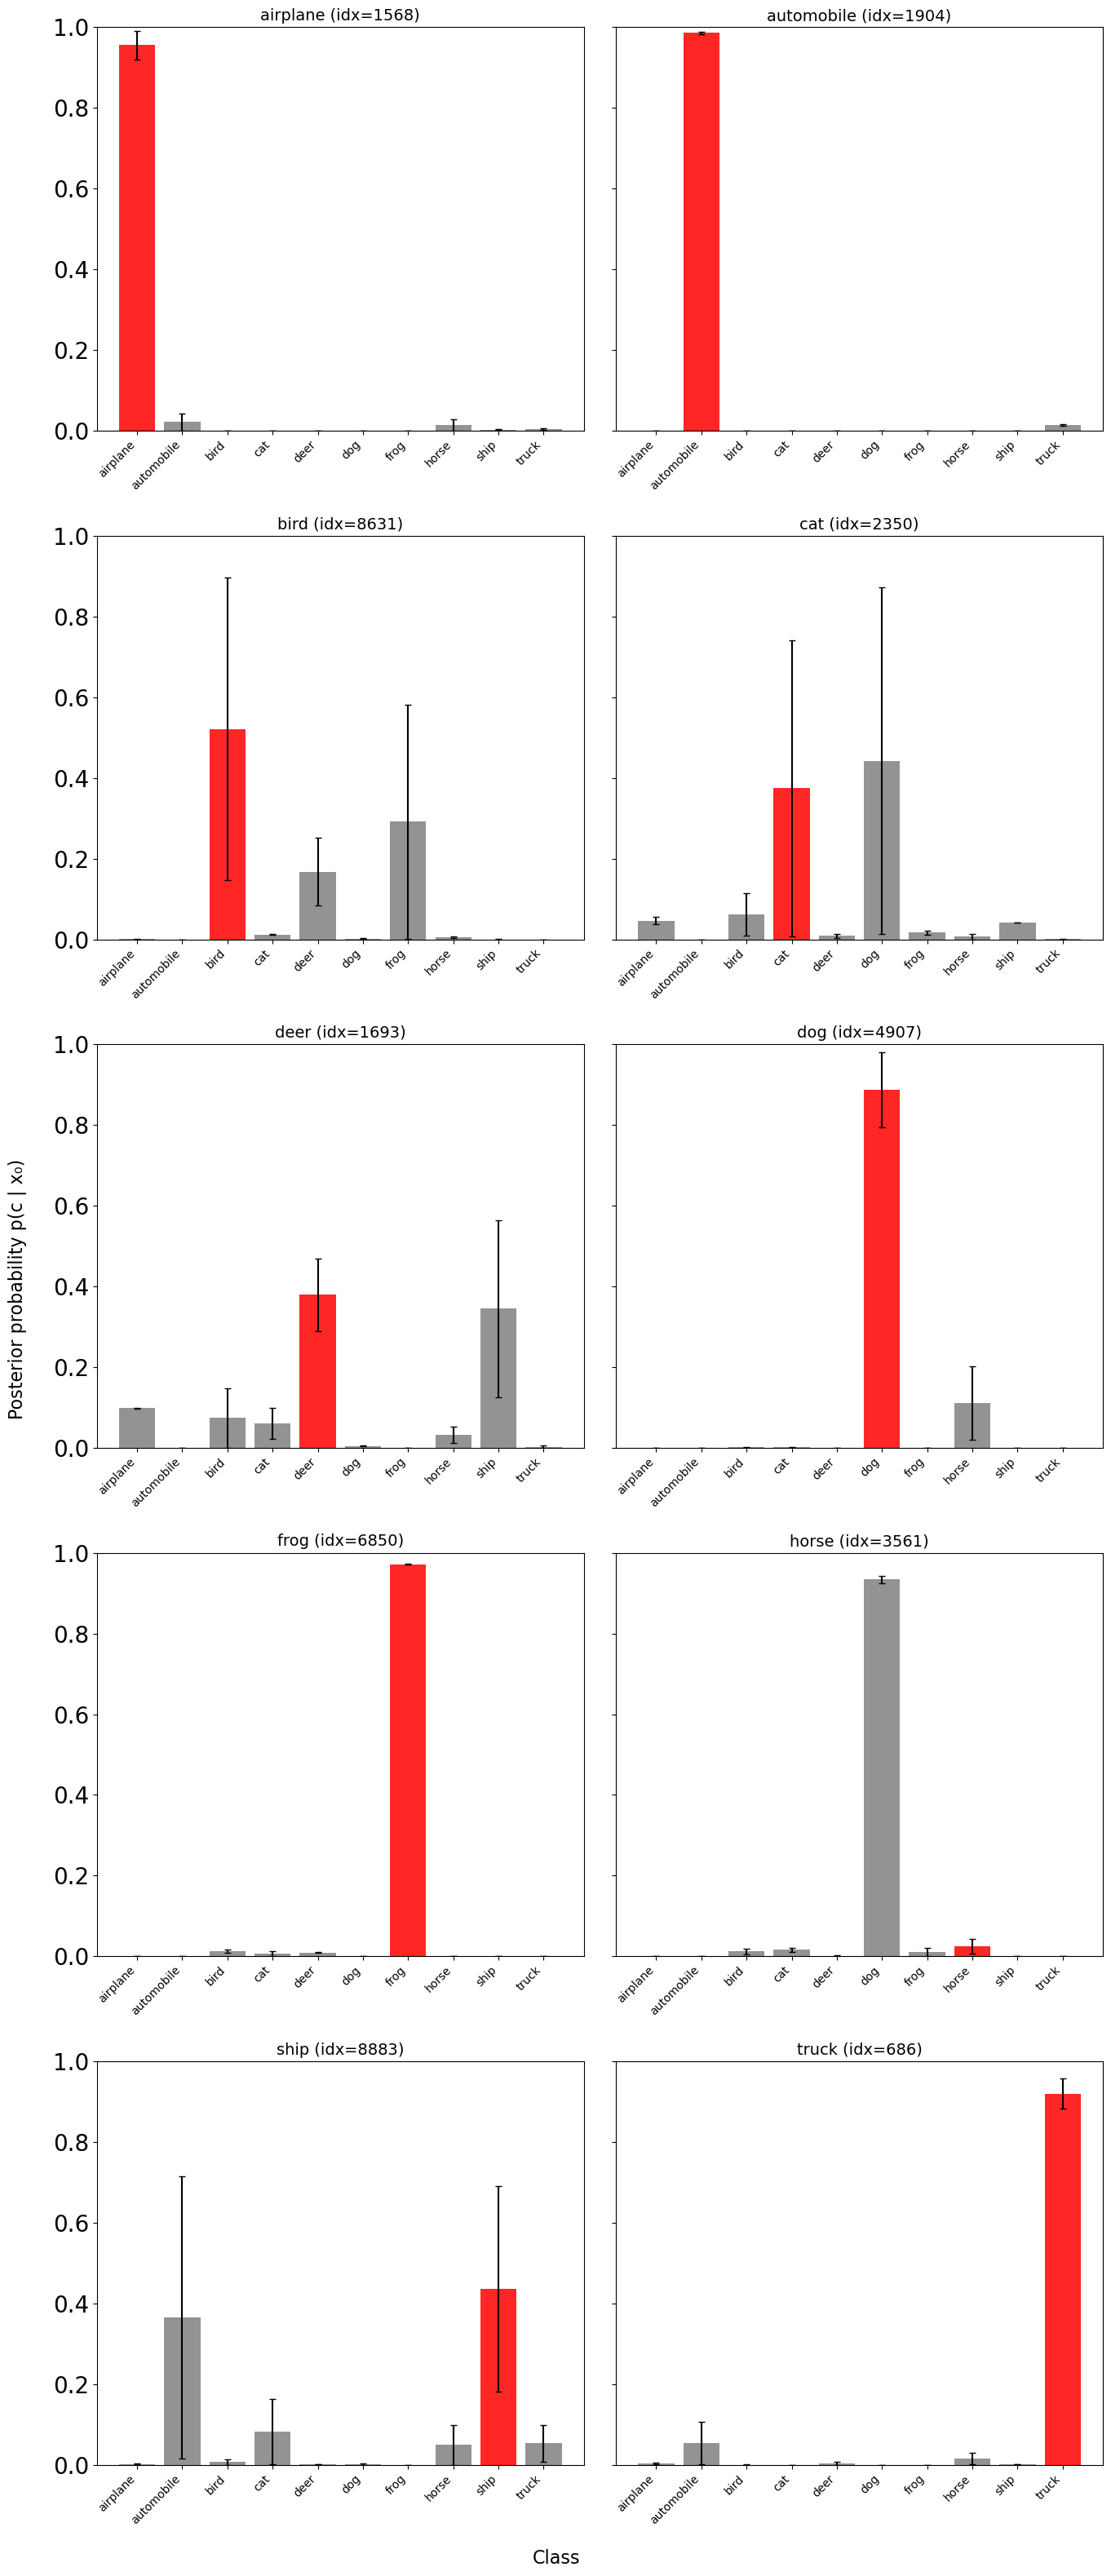

In [14]:
# =========================================================
# Diffusion–VAE Posterior Inference with Softmax Averaging
# One sample per class → 5×2 grid of posterior histograms
# =========================================================
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ------------------------------
# Paths & Parameters
# ------------------------------
NPZ_PATH    = "cifar10_resnet18_embeddings.npz"
CKPT_PATH   = "joint_diffusion_vae_best.pt"
SCALER_PATH = "embedding_scaler_stats.npz"
seed        = 1337
latent_dim  = 64
embed_dim   = 512
T_train     = T
T_eval      = T
n_paths     = 2
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed); np.random.seed(seed)

# =========================================================
# Load standardized test embeddings
# =========================================================
data = np.load(NPZ_PATH, allow_pickle=True)
Xtest, ytest = data["embeddings_test"], data["labels_test"]
classes = data["classes"].tolist() if "classes" in data else [str(i) for i in range(10)]
num_classes = len(classes)

# Standardize
stats = np.load(SCALER_PATH)
scaler = StandardScaler()
scaler.mean_, scaler.scale_ = stats["mean"], stats["scale"]
Xtest = scaler.transform(Xtest.astype(np.float32))
print(f"[info] Loaded standardized test embeddings: {Xtest.shape}")

# =========================================================
# Model definitions (identical to training)
# =========================================================
class ProgressiveVAE(nn.Module):
    def __init__(self, input_dim=512, latent_dim=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
        )
        self.mu, self.logvar = nn.Linear(128, latent_dim), nn.Linear(128, latent_dim)
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)
    def reparam(self, mu, logvar):
        return mu + torch.randn_like(mu)*torch.exp(0.5*logvar)
    def decode(self, z):
        return self.dec(z)

class FourierFeatures(nn.Module):
    def __init__(self, T, num_freqs=8):
        super().__init__()
        self.T = T
        freqs = 2**torch.arange(num_freqs).float() * math.pi
        self.register_buffer("freqs_buf", freqs)
    def forward(self, t):
        x = (t.float().unsqueeze(-1) / self.T) * self.freqs_buf
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(dim, dim)
        )
    def forward(self, x):
        return x + self.net(x)

class ConditionalDenoiser(nn.Module):
    def __init__(self, z_dim, num_classes, T, num_freqs=8, width=128, depth=3):
        super().__init__()
        self.ff = FourierFeatures(T, num_freqs)
        self.t_mlp = nn.Sequential(
            nn.Linear(2*num_freqs, 64), nn.GELU(), nn.Linear(64, 64)
        )
        self.y_emb = nn.Embedding(num_classes, 64)
        self.inp = nn.Linear(z_dim + 128, width)
        self.blocks = nn.ModuleList([ResidualBlock(width) for _ in range(depth)])
        self.out = nn.Sequential(nn.LayerNorm(width), nn.Linear(width, z_dim))
    def forward(self, zt, t, y):
        t_emb = self.t_mlp(self.ff(t))
        y_emb = self.y_emb(y)
        h = torch.cat([zt, t_emb, y_emb], dim=1)
        h = self.inp(h)
        for blk in self.blocks:
            h = blk(h)
        return self.out(h)

# =========================================================
# Load trained model
# =========================================================
vae = ProgressiveVAE(embed_dim, latent_dim).to(device)
denoiser = ConditionalDenoiser(latent_dim, num_classes, T_train).to(device)
ckpt = torch.load(CKPT_PATH, map_location=device)
vae.load_state_dict(ckpt["vae"])
denoiser.load_state_dict(ckpt["denoiser"])
vae.eval(); denoiser.eval()
betas = make_beta_schedule(T_train, kind).to(device)
print("[info] Model loaded successfully.")

# =========================================================
# Diffusion posterior estimator with softmax averaging
# =========================================================
def diffusion_posterior(z0_obs, denoiser, betas, T_train, y_classes,
                        n_paths=4, T_eval=None, device=None):
    if device is None:
        device = z0_obs.device
    if T_eval is None:
        T_eval = T_train

    B, D = z0_obs.shape
    C = len(y_classes)

    step_ids = np.linspace(1, T_train, T_eval, dtype=int)
    betas_sub = betas[step_ids - 1]
    alphas = 1. - betas_sub

    half = n_paths // 2
    eps_base = torch.randn(B, half, len(step_ids), D, device=device)
    eps = torch.cat([eps_base, -eps_base], dim=1)

    L_all = torch.zeros(B, n_paths, C, device=device)

    for cidx, c in enumerate(y_classes):
        y = torch.full((B,), int(c), device=device, dtype=torch.long)
        zt = z0_obs.unsqueeze(1).repeat(1, n_paths, 1)
        y_expand = y.unsqueeze(1).repeat(1, n_paths)
        ll_acc = torch.zeros(B, n_paths, device=device)

        for i, t_idx in enumerate(step_ids):
            beta_t = betas[t_idx - 1]
            noise = eps[:, :, i, :]
            zt1 = torch.sqrt(alphas[i]) * zt + torch.sqrt(1 - alphas[i]) * noise
            dz = zt1 - zt

            y_flat = y_expand.reshape(B * n_paths)
            zt1_flat = zt1.reshape(B * n_paths, D)
            t_vec = torch.full((B * n_paths,), t_idx, dtype=torch.long, device=device)
            score = denoiser(zt1_flat, t_vec, y_flat)

            ll_i = (score * dz.reshape(B * n_paths, D)).sum(dim=1)
            ll_i += 0.5 * beta_t * (
                -(score ** 2).sum(dim=1) +
                (zt1_flat * score).sum(dim=1)
            )
            ll_acc += ll_i.view(B, n_paths)
            zt = zt1.detach()

        L_all[:, :, cidx] = ll_acc

    probs = torch.softmax(L_all, dim=2)
    mean_probs = probs.mean(1)
    sem_probs = probs.std(1) / math.sqrt(n_paths)
    return mean_probs, sem_probs

# =========================================================
# Encode test embeddings
# =========================================================
Xtest_t = torch.tensor(Xtest, dtype=torch.float32, device=device)
with torch.no_grad():
    mu, logvar = vae.encode(Xtest_t)
ztest = mu
y_classes_torch = torch.arange(num_classes, device=device)

# =========================================================
# Pick 1 sample per class
# =========================================================
indices_per_class = []
for c in range(num_classes):
    idxs = np.where(ytest == c)[0]
    if len(idxs) == 0:
        print(f"[warn] No samples for class {c} ({classes[c]})")
        continue
    chosen = np.random.choice(idxs)
    indices_per_class.append(chosen)

print("[info] Selected indices per class:", indices_per_class)

# =========================================================
# Compute posteriors
# =========================================================
posterior_means = []
posterior_sems = []
true_labels = []

with torch.no_grad():
    for idx in indices_per_class:
        z0 = ztest[idx:idx+1]
        true_c = int(ytest[idx])

        mean_probs, sem_probs = diffusion_posterior(
            z0, denoiser, betas, T_train,
            y_classes_torch, n_paths=n_paths, T_eval=T_eval, device=device
        )

        mean_probs = mean_probs.squeeze(0).cpu().numpy()
        sem_probs  = sem_probs.squeeze(0).cpu().numpy()

        Z = mean_probs.sum()
        if Z > 0:
            mean_probs /= Z
            sem_probs /= Z

        posterior_means.append(mean_probs)
        posterior_sems.append(sem_probs)
        true_labels.append(true_c)

posterior_means = np.stack(posterior_means, axis=0)
posterior_sems  = np.stack(posterior_sems, axis=0)
true_labels     = np.array(true_labels)

# =========================================================
# Make a single 5×2 figure of posterior histograms
# =========================================================
n_to_plot = min(len(indices_per_class), 10)
rows, cols = 5, 2

fig, axes = plt.subplots(rows, cols, figsize=(14, 32), sharey=True)

for i in range(n_to_plot):
    r = i // cols
    c = i % cols
    ax = axes[r, c]

    mean_probs = posterior_means[i]
    sem_probs  = posterior_sems[i]
    true_c     = true_labels[i]
    idx        = indices_per_class[i]

    x = np.arange(num_classes)
    colors = ["gray"] * num_classes
    colors[true_c] = "red"

    ax.bar(
        x, mean_probs,
        yerr=sem_probs,
        capsize=3,
        alpha=0.85,
        color=colors
    )

    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha="right", fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title(f"{classes[true_c]} (idx={idx})", fontsize=14)

# Remove unused axes if any
for j in range(n_to_plot, rows * cols):
    r = j // cols
    c = j % cols
    fig.delaxes(axes[r, c])

fig.supylabel("Posterior probability p(c | x₀)", fontsize=16)
fig.supxlabel("Class", fontsize=16)
fig.tight_layout()
plt.show()

# optional save
fig.savefig("posterior_grid_5x2.svg", format="svg", bbox_inches="tight")


Chosen clear win idx=1, tie idx=24


/var/folders/tc/qjb0w1k122v4jzwncjlh51140000gp/T/ipykernel_88509/3382747750.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/tc/qjb0w1k122v4jzwncjlh51140000gp/T/ipykernel_88509/3382747750.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


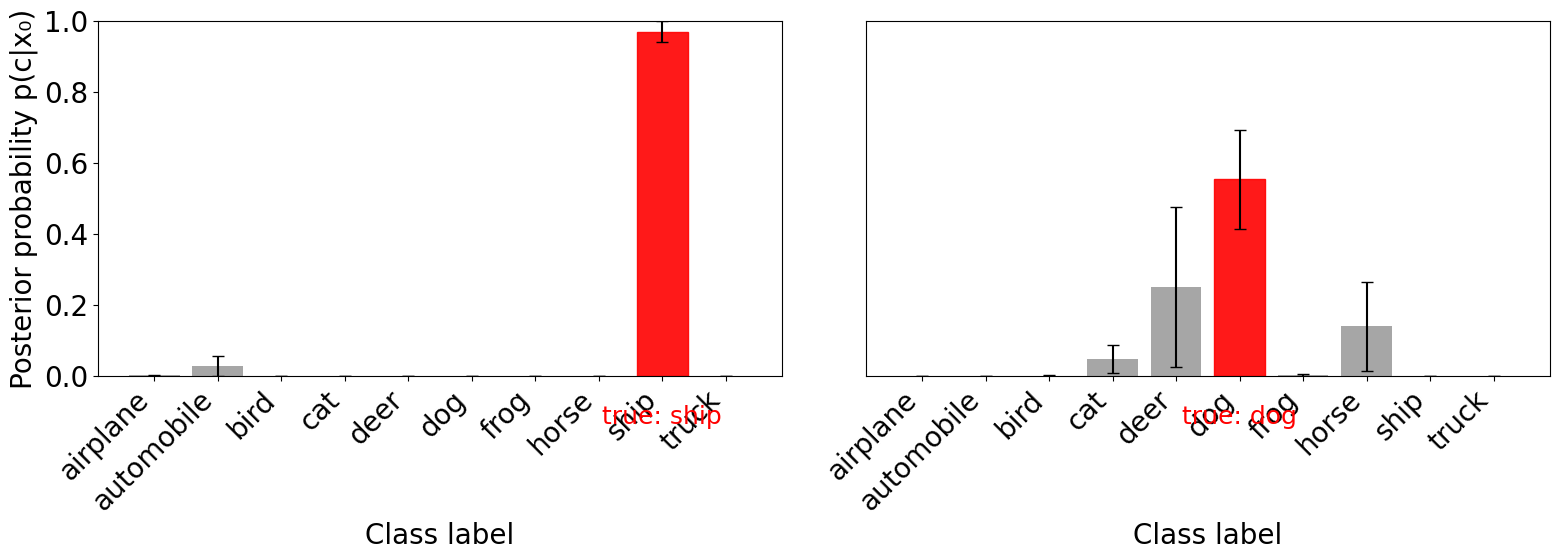

Saved figure as 'posterior_clear_vs_tie.svg'


In [7]:
# =========================================================
# Visualization: clear winner vs. tie case (minimalist, SVG)
# =========================================================
import matplotlib as mpl
mpl.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 18
})

def find_cases(ztest, ytest, denoiser, betas, T_train, y_classes, n_paths, T_eval, device):
    """Find one 'clear win' and one 'tie' example."""
    clear_idx, tie_idx = None, None
    for idx in range(len(ztest)):
        z0 = ztest[idx:idx+1]
        with torch.no_grad():
            mean_probs, _ = diffusion_posterior(
                z0, denoiser, betas, T_train, y_classes,
                n_paths=n_paths, T_eval=T_eval, device=device
            )
        probs = mean_probs.squeeze(0).cpu().numpy()
        probs /= probs.sum()
        sorted_probs = np.sort(probs)[::-1]
        gap = sorted_probs[0] - sorted_probs[1]
        if clear_idx is None and gap > 0.6:
            clear_idx = idx
        if tie_idx is None and 0.05 < gap < 0.15:
            tie_idx = idx
        if clear_idx is not None and tie_idx is not None:
            break
    return clear_idx, tie_idx

# --- find representative samples ---
idx_clear, idx_tie = find_cases(
    ztest, ytest, denoiser, betas, T_train, y_classes, n_paths, T_eval, device
)
print(f"Chosen clear win idx={idx_clear}, tie idx={idx_tie}")

# --- evaluate and plot both ---
cases = [idx_clear, idx_tie]
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

for i, (ax, idx) in enumerate(zip(axes, cases)):
    z0 = ztest[idx:idx+1]
    true_c = int(ytest[idx])
    with torch.no_grad():
        mean_probs, sem_probs = diffusion_posterior(
            z0, denoiser, betas, T_train,
            y_classes, n_paths=n_paths, T_eval=T_eval, device=device
        )
    mean_probs = mean_probs.squeeze(0).cpu().numpy()
    sem_probs  = sem_probs.squeeze(0).cpu().numpy()
    mean_probs /= mean_probs.sum()

    x = np.arange(num_classes)
    bars = ax.bar(
        x, mean_probs, yerr=sem_probs, capsize=4,
        color='gray', alpha=0.7
    )
    bars[true_c].set_color('red')
    bars[true_c].set_alpha(0.9)

    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Class label')

    if i == 0:
        ax.set_ylabel('Posterior probability p(c|x₀)')
    else:
        ax.set_ylabel('')
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)

    ax.tick_params(axis='x', which='both', bottom=True)
    ax.set_title('')
    ax.legend().remove()
    # Label the true class under the red bar
    ax.text(
        x[true_c], -0.08, f"true: {classes[true_c]}",
        ha='center', va='top', fontsize=18, color='red'
    )

plt.tight_layout()

# --- Save as SVG ---
plt.savefig("posterior_clear_vs_tie.svg", format="svg", bbox_inches="tight")
plt.show()

print("Saved figure as 'posterior_clear_vs_tie.svg'")


Diffusion posterior (batches):   1%|            | 1/157 [00:07<19:09,  7.37s/it]

[Running acc] VAE: 0.8594 | Diff(strict): 0.8125 | Diff(tie): 0.9219


Diffusion posterior (batches):   1%|▏           | 2/157 [00:14<18:54,  7.32s/it]

[Running acc] VAE: 0.8594 | Diff(strict): 0.8203 | Diff(tie): 0.8906


Diffusion posterior (batches):   2%|▏           | 3/157 [00:21<18:40,  7.27s/it]

[Running acc] VAE: 0.8594 | Diff(strict): 0.8125 | Diff(tie): 0.9010


Diffusion posterior (batches):   3%|▎           | 4/157 [00:29<18:28,  7.24s/it]

[Running acc] VAE: 0.8516 | Diff(strict): 0.8125 | Diff(tie): 0.9102


Diffusion posterior (batches):   3%|▍           | 5/157 [00:36<18:21,  7.25s/it]

[Running acc] VAE: 0.8406 | Diff(strict): 0.8094 | Diff(tie): 0.9125


Diffusion posterior (batches):   4%|▍           | 6/157 [00:43<18:11,  7.23s/it]

[Running acc] VAE: 0.8490 | Diff(strict): 0.8177 | Diff(tie): 0.9167


Diffusion posterior (batches):   4%|▌           | 7/157 [00:50<18:00,  7.20s/it]

[Running acc] VAE: 0.8527 | Diff(strict): 0.8170 | Diff(tie): 0.9107


Diffusion posterior (batches):   5%|▌           | 8/157 [00:57<17:54,  7.21s/it]

[Running acc] VAE: 0.8633 | Diff(strict): 0.8184 | Diff(tie): 0.9141


Diffusion posterior (batches):   6%|▋           | 9/157 [01:05<17:47,  7.21s/it]

[Running acc] VAE: 0.8715 | Diff(strict): 0.8264 | Diff(tie): 0.9149


Diffusion posterior (batches):   6%|▋          | 10/157 [01:12<18:01,  7.36s/it]

[Running acc] VAE: 0.8781 | Diff(strict): 0.8328 | Diff(tie): 0.9203


Diffusion posterior (batches):   7%|▊          | 11/157 [01:20<17:55,  7.37s/it]

[Running acc] VAE: 0.8764 | Diff(strict): 0.8338 | Diff(tie): 0.9205


Diffusion posterior (batches):   8%|▊          | 12/157 [01:27<17:39,  7.31s/it]

[Running acc] VAE: 0.8750 | Diff(strict): 0.8372 | Diff(tie): 0.9219


Diffusion posterior (batches):   8%|▉          | 13/157 [01:34<17:40,  7.36s/it]

[Running acc] VAE: 0.8774 | Diff(strict): 0.8353 | Diff(tie): 0.9219


Diffusion posterior (batches):   9%|▉          | 14/157 [01:42<17:26,  7.32s/it]

[Running acc] VAE: 0.8739 | Diff(strict): 0.8326 | Diff(tie): 0.9185


Diffusion posterior (batches):  10%|█          | 15/157 [01:49<17:15,  7.29s/it]

[Running acc] VAE: 0.8760 | Diff(strict): 0.8323 | Diff(tie): 0.9156


Diffusion posterior (batches):  10%|█          | 16/157 [01:56<17:05,  7.27s/it]

[Running acc] VAE: 0.8760 | Diff(strict): 0.8330 | Diff(tie): 0.9141


Diffusion posterior (batches):  11%|█▏         | 17/157 [02:03<16:59,  7.28s/it]

[Running acc] VAE: 0.8741 | Diff(strict): 0.8346 | Diff(tie): 0.9145


Diffusion posterior (batches):  11%|█▎         | 18/157 [02:10<16:46,  7.24s/it]

[Running acc] VAE: 0.8707 | Diff(strict): 0.8333 | Diff(tie): 0.9132


Diffusion posterior (batches):  12%|█▎         | 19/157 [02:18<16:36,  7.22s/it]

[Running acc] VAE: 0.8725 | Diff(strict): 0.8339 | Diff(tie): 0.9120


Diffusion posterior (batches):  13%|█▍         | 20/157 [02:25<16:27,  7.21s/it]

[Running acc] VAE: 0.8688 | Diff(strict): 0.8305 | Diff(tie): 0.9117


Diffusion posterior (batches):  13%|█▍         | 21/157 [02:32<16:21,  7.22s/it]

[Running acc] VAE: 0.8683 | Diff(strict): 0.8311 | Diff(tie): 0.9129


Diffusion posterior (batches):  14%|█▌         | 22/157 [02:39<16:17,  7.24s/it]

[Running acc] VAE: 0.8636 | Diff(strict): 0.8295 | Diff(tie): 0.9141


Diffusion posterior (batches):  15%|█▌         | 23/157 [02:47<16:07,  7.22s/it]

[Running acc] VAE: 0.8655 | Diff(strict): 0.8329 | Diff(tie): 0.9151


Diffusion posterior (batches):  15%|█▋         | 24/157 [02:54<15:58,  7.20s/it]

[Running acc] VAE: 0.8672 | Diff(strict): 0.8359 | Diff(tie): 0.9173


Diffusion posterior (batches):  16%|█▊         | 25/157 [03:01<15:53,  7.23s/it]

[Running acc] VAE: 0.8662 | Diff(strict): 0.8337 | Diff(tie): 0.9156


Diffusion posterior (batches):  17%|█▊         | 26/157 [03:08<15:45,  7.22s/it]

[Running acc] VAE: 0.8684 | Diff(strict): 0.8335 | Diff(tie): 0.9159


Diffusion posterior (batches):  17%|█▉         | 27/157 [03:15<15:37,  7.21s/it]

[Running acc] VAE: 0.8675 | Diff(strict): 0.8356 | Diff(tie): 0.9178


Diffusion posterior (batches):  18%|█▉         | 28/157 [03:23<15:29,  7.20s/it]

[Running acc] VAE: 0.8683 | Diff(strict): 0.8348 | Diff(tie): 0.9174


Diffusion posterior (batches):  18%|██         | 29/157 [03:30<15:20,  7.19s/it]

[Running acc] VAE: 0.8702 | Diff(strict): 0.8373 | Diff(tie): 0.9186


Diffusion posterior (batches):  19%|██         | 30/157 [03:37<15:15,  7.21s/it]

[Running acc] VAE: 0.8708 | Diff(strict): 0.8391 | Diff(tie): 0.9198


Diffusion posterior (batches):  20%|██▏        | 31/157 [03:44<15:06,  7.20s/it]

[Running acc] VAE: 0.8695 | Diff(strict): 0.8362 | Diff(tie): 0.9183


Diffusion posterior (batches):  20%|██▏        | 32/157 [03:51<14:59,  7.19s/it]

[Running acc] VAE: 0.8691 | Diff(strict): 0.8354 | Diff(tie): 0.9185


Diffusion posterior (batches):  21%|██▎        | 33/157 [03:59<14:52,  7.19s/it]

[Running acc] VAE: 0.8674 | Diff(strict): 0.8343 | Diff(tie): 0.9181


Diffusion posterior (batches):  22%|██▍        | 34/157 [04:06<14:44,  7.19s/it]

[Running acc] VAE: 0.8644 | Diff(strict): 0.8313 | Diff(tie): 0.9164


Diffusion posterior (batches):  22%|██▍        | 35/157 [04:13<14:38,  7.20s/it]

[Running acc] VAE: 0.8643 | Diff(strict): 0.8321 | Diff(tie): 0.9161


Diffusion posterior (batches):  23%|██▌        | 36/157 [04:20<14:31,  7.20s/it]

[Running acc] VAE: 0.8633 | Diff(strict): 0.8307 | Diff(tie): 0.9149


Diffusion posterior (batches):  24%|██▌        | 37/157 [04:27<14:27,  7.23s/it]

[Running acc] VAE: 0.8619 | Diff(strict): 0.8315 | Diff(tie): 0.9147


Diffusion posterior (batches):  24%|██▋        | 38/157 [04:35<14:24,  7.26s/it]

[Running acc] VAE: 0.8623 | Diff(strict): 0.8314 | Diff(tie): 0.9149


Diffusion posterior (batches):  25%|██▋        | 39/157 [04:42<14:18,  7.28s/it]

[Running acc] VAE: 0.8630 | Diff(strict): 0.8317 | Diff(tie): 0.9147


Diffusion posterior (batches):  25%|██▊        | 40/157 [04:49<14:09,  7.26s/it]

[Running acc] VAE: 0.8609 | Diff(strict): 0.8309 | Diff(tie): 0.9141


Diffusion posterior (batches):  26%|██▊        | 41/157 [04:57<14:01,  7.26s/it]

[Running acc] VAE: 0.8601 | Diff(strict): 0.8312 | Diff(tie): 0.9135


Diffusion posterior (batches):  27%|██▉        | 42/157 [05:04<14:12,  7.41s/it]

[Running acc] VAE: 0.8605 | Diff(strict): 0.8318 | Diff(tie): 0.9133


Diffusion posterior (batches):  27%|███        | 43/157 [05:12<14:02,  7.39s/it]

[Running acc] VAE: 0.8612 | Diff(strict): 0.8325 | Diff(tie): 0.9139


Diffusion posterior (batches):  28%|███        | 44/157 [05:19<13:47,  7.32s/it]

[Running acc] VAE: 0.8597 | Diff(strict): 0.8324 | Diff(tie): 0.9141


Diffusion posterior (batches):  29%|███▏       | 45/157 [05:26<13:34,  7.27s/it]

[Running acc] VAE: 0.8608 | Diff(strict): 0.8313 | Diff(tie): 0.9156


Diffusion posterior (batches):  29%|███▏       | 46/157 [05:33<13:25,  7.26s/it]

[Running acc] VAE: 0.8624 | Diff(strict): 0.8315 | Diff(tie): 0.9154


Diffusion posterior (batches):  30%|███▎       | 47/157 [05:40<13:15,  7.23s/it]

[Running acc] VAE: 0.8630 | Diff(strict): 0.8321 | Diff(tie): 0.9152


Diffusion posterior (batches):  31%|███▎       | 48/157 [05:48<13:07,  7.22s/it]

[Running acc] VAE: 0.8630 | Diff(strict): 0.8307 | Diff(tie): 0.9137


Diffusion posterior (batches):  31%|███▍       | 49/157 [05:55<12:58,  7.21s/it]

[Running acc] VAE: 0.8635 | Diff(strict): 0.8313 | Diff(tie): 0.9133


Diffusion posterior (batches):  32%|███▌       | 50/157 [06:02<12:49,  7.19s/it]

[Running acc] VAE: 0.8634 | Diff(strict): 0.8313 | Diff(tie): 0.9134


Diffusion posterior (batches):  32%|███▌       | 51/157 [06:09<12:41,  7.18s/it]

[Running acc] VAE: 0.8624 | Diff(strict): 0.8312 | Diff(tie): 0.9130


Diffusion posterior (batches):  33%|███▋       | 52/157 [06:16<12:34,  7.18s/it]

[Running acc] VAE: 0.8630 | Diff(strict): 0.8317 | Diff(tie): 0.9132


Diffusion posterior (batches):  34%|███▋       | 53/157 [06:23<12:25,  7.17s/it]

[Running acc] VAE: 0.8620 | Diff(strict): 0.8308 | Diff(tie): 0.9127


Diffusion posterior (batches):  34%|███▊       | 54/157 [06:31<12:18,  7.17s/it]

[Running acc] VAE: 0.8626 | Diff(strict): 0.8313 | Diff(tie): 0.9129


Diffusion posterior (batches):  35%|███▊       | 55/157 [06:38<12:12,  7.19s/it]

[Running acc] VAE: 0.8631 | Diff(strict): 0.8318 | Diff(tie): 0.9136


Diffusion posterior (batches):  36%|███▉       | 56/157 [06:45<12:04,  7.17s/it]

[Running acc] VAE: 0.8638 | Diff(strict): 0.8320 | Diff(tie): 0.9141


Diffusion posterior (batches):  36%|███▉       | 57/157 [06:52<11:56,  7.16s/it]

[Running acc] VAE: 0.8635 | Diff(strict): 0.8311 | Diff(tie): 0.9142


Diffusion posterior (batches):  37%|████       | 58/157 [06:59<11:48,  7.16s/it]

[Running acc] VAE: 0.8640 | Diff(strict): 0.8314 | Diff(tie): 0.9146


Diffusion posterior (batches):  38%|████▏      | 59/157 [07:06<11:40,  7.15s/it]

[Running acc] VAE: 0.8639 | Diff(strict): 0.8302 | Diff(tie): 0.9129


Diffusion posterior (batches):  38%|████▏      | 60/157 [07:13<11:32,  7.14s/it]

[Running acc] VAE: 0.8635 | Diff(strict): 0.8297 | Diff(tie): 0.9128


Diffusion posterior (batches):  39%|████▎      | 61/157 [07:21<11:25,  7.14s/it]

[Running acc] VAE: 0.8632 | Diff(strict): 0.8304 | Diff(tie): 0.9124


Diffusion posterior (batches):  39%|████▎      | 62/157 [07:28<11:17,  7.13s/it]

[Running acc] VAE: 0.8637 | Diff(strict): 0.8311 | Diff(tie): 0.9123


Diffusion posterior (batches):  40%|████▍      | 63/157 [07:35<11:12,  7.16s/it]

[Running acc] VAE: 0.8641 | Diff(strict): 0.8311 | Diff(tie): 0.9125


Diffusion posterior (batches):  41%|████▍      | 64/157 [07:42<11:05,  7.16s/it]

[Running acc] VAE: 0.8635 | Diff(strict): 0.8306 | Diff(tie): 0.9119


Diffusion posterior (batches):  41%|████▌      | 65/157 [07:49<10:58,  7.16s/it]

[Running acc] VAE: 0.8637 | Diff(strict): 0.8310 | Diff(tie): 0.9118


Diffusion posterior (batches):  42%|████▌      | 66/157 [07:56<10:52,  7.17s/it]

[Running acc] VAE: 0.8639 | Diff(strict): 0.8307 | Diff(tie): 0.9119


Diffusion posterior (batches):  43%|████▋      | 67/157 [08:04<10:46,  7.18s/it]

[Running acc] VAE: 0.8640 | Diff(strict): 0.8305 | Diff(tie): 0.9116


Diffusion posterior (batches):  43%|████▊      | 68/157 [08:11<10:42,  7.21s/it]

[Running acc] VAE: 0.8649 | Diff(strict): 0.8311 | Diff(tie): 0.9125


Diffusion posterior (batches):  44%|████▊      | 69/157 [08:18<10:33,  7.20s/it]

[Running acc] VAE: 0.8655 | Diff(strict): 0.8324 | Diff(tie): 0.9130


Diffusion posterior (batches):  45%|████▉      | 70/157 [08:26<10:31,  7.26s/it]

[Running acc] VAE: 0.8658 | Diff(strict): 0.8328 | Diff(tie): 0.9138


Diffusion posterior (batches):  45%|████▉      | 71/157 [08:33<10:27,  7.30s/it]

[Running acc] VAE: 0.8662 | Diff(strict): 0.8334 | Diff(tie): 0.9144


Diffusion posterior (batches):  46%|█████      | 72/157 [08:40<10:15,  7.25s/it]

[Running acc] VAE: 0.8655 | Diff(strict): 0.8327 | Diff(tie): 0.9136


Diffusion posterior (batches):  46%|█████      | 73/157 [08:47<10:06,  7.22s/it]

[Running acc] VAE: 0.8645 | Diff(strict): 0.8322 | Diff(tie): 0.9135


Diffusion posterior (batches):  47%|█████▏     | 74/157 [08:54<09:56,  7.19s/it]

[Running acc] VAE: 0.8647 | Diff(strict): 0.8326 | Diff(tie): 0.9139


Diffusion posterior (batches):  48%|█████▎     | 75/157 [09:01<09:48,  7.18s/it]

[Running acc] VAE: 0.8642 | Diff(strict): 0.8315 | Diff(tie): 0.9129


Diffusion posterior (batches):  48%|█████▎     | 76/157 [09:09<09:41,  7.17s/it]

[Running acc] VAE: 0.8649 | Diff(strict): 0.8322 | Diff(tie): 0.9134


Diffusion posterior (batches):  49%|█████▍     | 77/157 [09:16<09:33,  7.16s/it]

[Running acc] VAE: 0.8647 | Diff(strict): 0.8322 | Diff(tie): 0.9134


Diffusion posterior (batches):  50%|█████▍     | 78/157 [09:23<09:29,  7.20s/it]

[Running acc] VAE: 0.8636 | Diff(strict): 0.8311 | Diff(tie): 0.9129


Diffusion posterior (batches):  50%|█████▌     | 79/157 [09:30<09:19,  7.18s/it]

[Running acc] VAE: 0.8633 | Diff(strict): 0.8311 | Diff(tie): 0.9130


Diffusion posterior (batches):  51%|█████▌     | 80/157 [09:37<09:16,  7.22s/it]

[Running acc] VAE: 0.8627 | Diff(strict): 0.8297 | Diff(tie): 0.9125


Diffusion posterior (batches):  52%|█████▋     | 81/157 [09:45<09:11,  7.26s/it]

[Running acc] VAE: 0.8632 | Diff(strict): 0.8304 | Diff(tie): 0.9126


Diffusion posterior (batches):  52%|█████▋     | 82/157 [09:52<09:05,  7.27s/it]

[Running acc] VAE: 0.8626 | Diff(strict): 0.8298 | Diff(tie): 0.9123


Diffusion posterior (batches):  53%|█████▊     | 83/157 [09:59<08:55,  7.24s/it]

[Running acc] VAE: 0.8635 | Diff(strict): 0.8308 | Diff(tie): 0.9128


Diffusion posterior (batches):  54%|█████▉     | 84/157 [10:06<08:46,  7.22s/it]

[Running acc] VAE: 0.8635 | Diff(strict): 0.8307 | Diff(tie): 0.9128


Diffusion posterior (batches):  54%|█████▉     | 85/157 [10:14<08:38,  7.20s/it]

[Running acc] VAE: 0.8631 | Diff(strict): 0.8301 | Diff(tie): 0.9121


Diffusion posterior (batches):  55%|██████     | 86/157 [10:21<08:30,  7.18s/it]

[Running acc] VAE: 0.8630 | Diff(strict): 0.8305 | Diff(tie): 0.9122


Diffusion posterior (batches):  55%|██████     | 87/157 [10:28<08:22,  7.18s/it]

[Running acc] VAE: 0.8630 | Diff(strict): 0.8299 | Diff(tie): 0.9124


Diffusion posterior (batches):  56%|██████▏    | 88/157 [10:35<08:21,  7.27s/it]

[Running acc] VAE: 0.8631 | Diff(strict): 0.8295 | Diff(tie): 0.9119


Diffusion posterior (batches):  57%|██████▏    | 89/157 [10:43<08:12,  7.24s/it]

[Running acc] VAE: 0.8620 | Diff(strict): 0.8288 | Diff(tie): 0.9117


Diffusion posterior (batches):  57%|██████▎    | 90/157 [10:50<08:05,  7.25s/it]

[Running acc] VAE: 0.8618 | Diff(strict): 0.8285 | Diff(tie): 0.9120


Diffusion posterior (batches):  58%|██████▍    | 91/157 [10:57<07:55,  7.21s/it]

[Running acc] VAE: 0.8620 | Diff(strict): 0.8285 | Diff(tie): 0.9119


Diffusion posterior (batches):  59%|██████▍    | 92/157 [11:04<07:47,  7.19s/it]

[Running acc] VAE: 0.8618 | Diff(strict): 0.8281 | Diff(tie): 0.9119


Diffusion posterior (batches):  59%|██████▌    | 93/157 [11:11<07:41,  7.21s/it]

[Running acc] VAE: 0.8621 | Diff(strict): 0.8285 | Diff(tie): 0.9121


Diffusion posterior (batches):  60%|██████▌    | 94/157 [11:19<07:35,  7.23s/it]

[Running acc] VAE: 0.8614 | Diff(strict): 0.8285 | Diff(tie): 0.9122


Diffusion posterior (batches):  61%|██████▋    | 95/157 [11:26<07:29,  7.25s/it]

[Running acc] VAE: 0.8615 | Diff(strict): 0.8288 | Diff(tie): 0.9125


Diffusion posterior (batches):  61%|██████▋    | 96/157 [11:33<07:23,  7.27s/it]

[Running acc] VAE: 0.8621 | Diff(strict): 0.8289 | Diff(tie): 0.9126


Diffusion posterior (batches):  62%|██████▊    | 97/157 [11:40<07:14,  7.25s/it]

[Running acc] VAE: 0.8616 | Diff(strict): 0.8283 | Diff(tie): 0.9122


Diffusion posterior (batches):  62%|██████▊    | 98/157 [11:48<07:06,  7.23s/it]

[Running acc] VAE: 0.8610 | Diff(strict): 0.8273 | Diff(tie): 0.9118


Diffusion posterior (batches):  63%|██████▉    | 99/157 [11:55<06:57,  7.21s/it]

[Running acc] VAE: 0.8621 | Diff(strict): 0.8284 | Diff(tie): 0.9122


Diffusion posterior (batches):  64%|██████▎   | 100/157 [12:02<06:50,  7.20s/it]

[Running acc] VAE: 0.8620 | Diff(strict): 0.8286 | Diff(tie): 0.9127


Diffusion posterior (batches):  64%|██████▍   | 101/157 [12:09<06:42,  7.19s/it]

[Running acc] VAE: 0.8615 | Diff(strict): 0.8287 | Diff(tie): 0.9131


Diffusion posterior (batches):  65%|██████▍   | 102/157 [12:16<06:37,  7.22s/it]

[Running acc] VAE: 0.8614 | Diff(strict): 0.8284 | Diff(tie): 0.9127


Diffusion posterior (batches):  66%|██████▌   | 103/157 [12:24<06:30,  7.23s/it]

[Running acc] VAE: 0.8612 | Diff(strict): 0.8281 | Diff(tie): 0.9125


Diffusion posterior (batches):  66%|██████▌   | 104/157 [12:31<06:24,  7.25s/it]

[Running acc] VAE: 0.8616 | Diff(strict): 0.8286 | Diff(tie): 0.9130


Diffusion posterior (batches):  67%|██████▋   | 105/157 [12:38<06:16,  7.24s/it]

[Running acc] VAE: 0.8616 | Diff(strict): 0.8280 | Diff(tie): 0.9131


Diffusion posterior (batches):  68%|██████▊   | 106/157 [12:45<06:09,  7.24s/it]

[Running acc] VAE: 0.8616 | Diff(strict): 0.8275 | Diff(tie): 0.9132


Diffusion posterior (batches):  68%|██████▊   | 107/157 [12:53<06:03,  7.27s/it]

[Running acc] VAE: 0.8620 | Diff(strict): 0.8284 | Diff(tie): 0.9134


Diffusion posterior (batches):  69%|██████▉   | 108/157 [13:00<05:56,  7.28s/it]

[Running acc] VAE: 0.8617 | Diff(strict): 0.8281 | Diff(tie): 0.9132


Diffusion posterior (batches):  69%|██████▉   | 109/157 [13:07<05:49,  7.28s/it]

[Running acc] VAE: 0.8614 | Diff(strict): 0.8276 | Diff(tie): 0.9130


Diffusion posterior (batches):  70%|███████   | 110/157 [13:15<05:44,  7.32s/it]

[Running acc] VAE: 0.8611 | Diff(strict): 0.8266 | Diff(tie): 0.9125


Diffusion posterior (batches):  71%|███████   | 111/157 [13:22<05:34,  7.28s/it]

[Running acc] VAE: 0.8612 | Diff(strict): 0.8267 | Diff(tie): 0.9123


Diffusion posterior (batches):  71%|███████▏  | 112/157 [13:29<05:26,  7.26s/it]

[Running acc] VAE: 0.8609 | Diff(strict): 0.8269 | Diff(tie): 0.9125


Diffusion posterior (batches):  72%|███████▏  | 113/157 [13:36<05:19,  7.26s/it]

[Running acc] VAE: 0.8606 | Diff(strict): 0.8265 | Diff(tie): 0.9127


Diffusion posterior (batches):  73%|███████▎  | 114/157 [13:44<05:11,  7.25s/it]

[Running acc] VAE: 0.8610 | Diff(strict): 0.8272 | Diff(tie): 0.9132


Diffusion posterior (batches):  73%|███████▎  | 115/157 [13:51<05:03,  7.24s/it]

[Running acc] VAE: 0.8614 | Diff(strict): 0.8274 | Diff(tie): 0.9133


Diffusion posterior (batches):  74%|███████▍  | 116/157 [13:58<04:56,  7.24s/it]

[Running acc] VAE: 0.8613 | Diff(strict): 0.8273 | Diff(tie): 0.9131


Diffusion posterior (batches):  75%|███████▍  | 117/157 [14:05<04:48,  7.22s/it]

[Running acc] VAE: 0.8610 | Diff(strict): 0.8271 | Diff(tie): 0.9131


Diffusion posterior (batches):  75%|███████▌  | 118/157 [14:13<04:41,  7.22s/it]

[Running acc] VAE: 0.8610 | Diff(strict): 0.8272 | Diff(tie): 0.9131


Diffusion posterior (batches):  76%|███████▌  | 119/157 [14:20<04:33,  7.20s/it]

[Running acc] VAE: 0.8613 | Diff(strict): 0.8277 | Diff(tie): 0.9132


Diffusion posterior (batches):  76%|███████▋  | 120/157 [14:27<04:26,  7.22s/it]

[Running acc] VAE: 0.8609 | Diff(strict): 0.8268 | Diff(tie): 0.9129


Diffusion posterior (batches):  77%|███████▋  | 121/157 [14:34<04:19,  7.22s/it]

[Running acc] VAE: 0.8608 | Diff(strict): 0.8263 | Diff(tie): 0.9126


Diffusion posterior (batches):  78%|███████▊  | 122/157 [14:41<04:13,  7.24s/it]

[Running acc] VAE: 0.8607 | Diff(strict): 0.8262 | Diff(tie): 0.9125


Diffusion posterior (batches):  78%|███████▊  | 123/157 [14:49<04:06,  7.24s/it]

[Running acc] VAE: 0.8601 | Diff(strict): 0.8258 | Diff(tie): 0.9123


Diffusion posterior (batches):  79%|███████▉  | 124/157 [14:56<03:59,  7.25s/it]

[Running acc] VAE: 0.8601 | Diff(strict): 0.8255 | Diff(tie): 0.9119


Diffusion posterior (batches):  80%|███████▉  | 125/157 [15:03<03:51,  7.24s/it]

[Running acc] VAE: 0.8601 | Diff(strict): 0.8249 | Diff(tie): 0.9119


Diffusion posterior (batches):  80%|████████  | 126/157 [15:10<03:44,  7.24s/it]

[Running acc] VAE: 0.8602 | Diff(strict): 0.8251 | Diff(tie): 0.9121


Diffusion posterior (batches):  81%|████████  | 127/157 [15:18<03:37,  7.24s/it]

[Running acc] VAE: 0.8607 | Diff(strict): 0.8252 | Diff(tie): 0.9123


Diffusion posterior (batches):  82%|████████▏ | 128/157 [15:25<03:30,  7.24s/it]

[Running acc] VAE: 0.8612 | Diff(strict): 0.8254 | Diff(tie): 0.9125


Diffusion posterior (batches):  82%|████████▏ | 129/157 [15:32<03:23,  7.28s/it]

[Running acc] VAE: 0.8616 | Diff(strict): 0.8255 | Diff(tie): 0.9122


Diffusion posterior (batches):  83%|████████▎ | 130/157 [15:40<03:16,  7.28s/it]

[Running acc] VAE: 0.8614 | Diff(strict): 0.8254 | Diff(tie): 0.9119


Diffusion posterior (batches):  83%|████████▎ | 131/157 [15:47<03:09,  7.29s/it]

[Running acc] VAE: 0.8615 | Diff(strict): 0.8249 | Diff(tie): 0.9115


Diffusion posterior (batches):  84%|████████▍ | 132/157 [15:54<03:01,  7.27s/it]

[Running acc] VAE: 0.8614 | Diff(strict): 0.8243 | Diff(tie): 0.9116


Diffusion posterior (batches):  85%|████████▍ | 133/157 [16:01<02:54,  7.28s/it]

[Running acc] VAE: 0.8610 | Diff(strict): 0.8242 | Diff(tie): 0.9117


Diffusion posterior (batches):  85%|████████▌ | 134/157 [16:09<02:47,  7.29s/it]

[Running acc] VAE: 0.8611 | Diff(strict): 0.8245 | Diff(tie): 0.9115


Diffusion posterior (batches):  86%|████████▌ | 135/157 [16:16<02:40,  7.31s/it]

[Running acc] VAE: 0.8612 | Diff(strict): 0.8248 | Diff(tie): 0.9118


Diffusion posterior (batches):  87%|████████▋ | 136/157 [16:23<02:33,  7.32s/it]

[Running acc] VAE: 0.8611 | Diff(strict): 0.8251 | Diff(tie): 0.9121


Diffusion posterior (batches):  87%|████████▋ | 137/157 [16:31<02:26,  7.30s/it]

[Running acc] VAE: 0.8611 | Diff(strict): 0.8255 | Diff(tie): 0.9123


Diffusion posterior (batches):  88%|████████▊ | 138/157 [16:38<02:18,  7.30s/it]

[Running acc] VAE: 0.8611 | Diff(strict): 0.8254 | Diff(tie): 0.9120


Diffusion posterior (batches):  89%|████████▊ | 139/157 [16:45<02:11,  7.29s/it]

[Running acc] VAE: 0.8608 | Diff(strict): 0.8255 | Diff(tie): 0.9119


Diffusion posterior (batches):  89%|████████▉ | 140/157 [16:52<02:03,  7.28s/it]

[Running acc] VAE: 0.8610 | Diff(strict): 0.8261 | Diff(tie): 0.9119


Diffusion posterior (batches):  90%|████████▉ | 141/157 [17:00<01:56,  7.27s/it]

[Running acc] VAE: 0.8611 | Diff(strict): 0.8265 | Diff(tie): 0.9122


Diffusion posterior (batches):  90%|█████████ | 142/157 [17:07<01:49,  7.30s/it]

[Running acc] VAE: 0.8614 | Diff(strict): 0.8261 | Diff(tie): 0.9122


Diffusion posterior (batches):  91%|█████████ | 143/157 [17:14<01:42,  7.29s/it]

[Running acc] VAE: 0.8612 | Diff(strict): 0.8262 | Diff(tie): 0.9122


Diffusion posterior (batches):  92%|█████████▏| 144/157 [17:22<01:34,  7.29s/it]

[Running acc] VAE: 0.8618 | Diff(strict): 0.8265 | Diff(tie): 0.9127


Diffusion posterior (batches):  92%|█████████▏| 145/157 [17:29<01:27,  7.30s/it]

[Running acc] VAE: 0.8611 | Diff(strict): 0.8262 | Diff(tie): 0.9124


Diffusion posterior (batches):  93%|█████████▎| 146/157 [17:36<01:20,  7.28s/it]

[Running acc] VAE: 0.8609 | Diff(strict): 0.8265 | Diff(tie): 0.9125


Diffusion posterior (batches):  94%|█████████▎| 147/157 [17:43<01:12,  7.28s/it]

[Running acc] VAE: 0.8610 | Diff(strict): 0.8266 | Diff(tie): 0.9125


Diffusion posterior (batches):  94%|█████████▍| 148/157 [17:51<01:05,  7.28s/it]

[Running acc] VAE: 0.8611 | Diff(strict): 0.8261 | Diff(tie): 0.9126


Diffusion posterior (batches):  95%|█████████▍| 149/157 [17:58<00:58,  7.29s/it]

[Running acc] VAE: 0.8612 | Diff(strict): 0.8264 | Diff(tie): 0.9128


Diffusion posterior (batches):  96%|█████████▌| 150/157 [18:05<00:50,  7.26s/it]

[Running acc] VAE: 0.8615 | Diff(strict): 0.8271 | Diff(tie): 0.9130


Diffusion posterior (batches):  96%|█████████▌| 151/157 [18:12<00:43,  7.24s/it]

[Running acc] VAE: 0.8614 | Diff(strict): 0.8273 | Diff(tie): 0.9128


Diffusion posterior (batches):  97%|█████████▋| 152/157 [18:20<00:36,  7.24s/it]

[Running acc] VAE: 0.8617 | Diff(strict): 0.8272 | Diff(tie): 0.9128


Diffusion posterior (batches):  97%|█████████▋| 153/157 [18:27<00:28,  7.23s/it]

[Running acc] VAE: 0.8615 | Diff(strict): 0.8269 | Diff(tie): 0.9126


Diffusion posterior (batches):  98%|█████████▊| 154/157 [18:34<00:21,  7.22s/it]

[Running acc] VAE: 0.8613 | Diff(strict): 0.8268 | Diff(tie): 0.9123


Diffusion posterior (batches):  99%|█████████▊| 155/157 [18:41<00:14,  7.21s/it]

[Running acc] VAE: 0.8614 | Diff(strict): 0.8266 | Diff(tie): 0.9122


Diffusion posterior (batches):  99%|█████████▉| 156/157 [18:48<00:07,  7.19s/it]

[Running acc] VAE: 0.8614 | Diff(strict): 0.8263 | Diff(tie): 0.9120


Diffusion posterior (batches): 100%|██████████| 157/157 [18:53<00:00,  7.22s/it]


[Running acc] VAE: 0.8614 | Diff(strict): 0.8264 | Diff(tie): 0.9120

========== FINAL ACCURACIES ==========
Strict Top-1 (VAE): 0.8614
Strict Top-1 (Diffusion): 0.8264
Tie-aware Top-1 (Diffusion): 0.9120
Tie-aware Top-2 (Diffusion): 0.9796
Tie-aware Top-3 (Diffusion): 0.9902
Tie-aware Top-4 (Diffusion): 0.9960
Tie-aware Top-5 (Diffusion): 0.9986

Classification Report (VAE strict top-1):
              precision    recall  f1-score   support

    airplane      0.872     0.879     0.875      1000
  automobile      0.921     0.907     0.914      1000
        bird      0.839     0.814     0.826      1000
         cat      0.759     0.752     0.755      1000
        deer      0.830     0.824     0.827      1000
         dog      0.832     0.793     0.812      1000
        frog      0.874     0.921     0.897      1000
       horse      0.861     0.886     0.873      1000
        ship      0.918     0.922     0.920      1000
       truck      0.904     0.916     0.910      1000

    accuracy

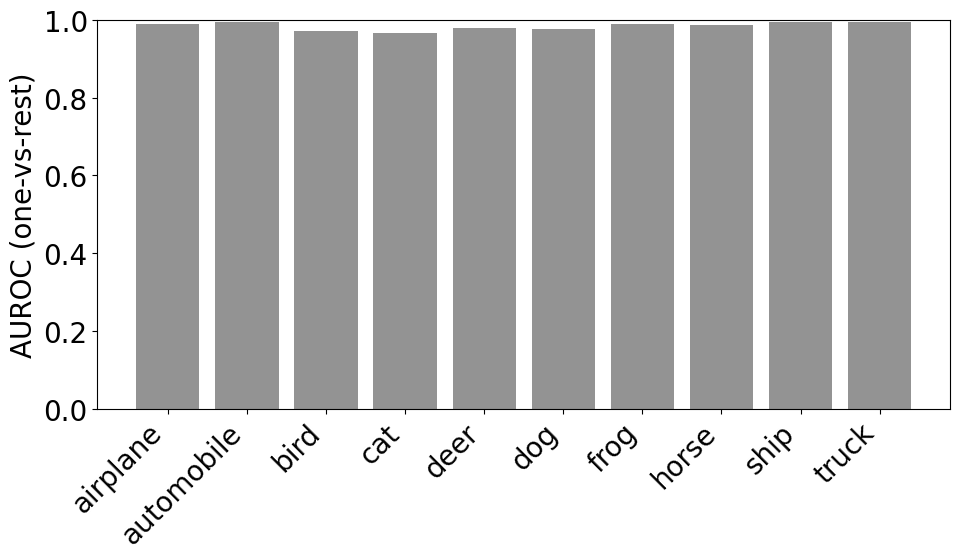

Saved: diffusion_posterior_aurocs.svg


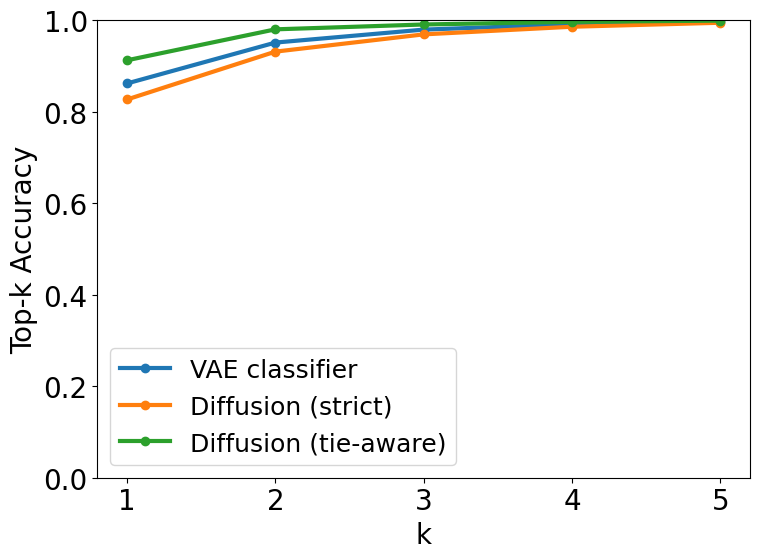

Saved: topk_accuracy_comparison.svg


In [10]:
# =========================================================
# Diffusion–VAE: tie-aware eval + AUROC + top-k comparison
# WITH RUNNING ACCURACY DURING POSTERIOR EVALUATION
# =========================================================
import numpy as np, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from tqdm import tqdm

# ---------- Assumes these already exist ----------
# diffusion_posterior(...)
# vae, denoiser, betas, T_train, T_eval, n_paths, device
# Xtest, ytest, classes, num_classes, embed_dim, latent_dim
# clf (VAE classifier)
# -------------------------------------------------

# ================= Encode test set =================
BATCH = 64
TIE_THRESHOLD = 1.0
TOP_K_LIST = [1,2,3,4,5]

Xtest_t = torch.tensor(Xtest, dtype=torch.float32, device=device)
with torch.no_grad():
    mu, logvar = vae.encode(Xtest_t)
ztest = mu
ytest_np = np.asarray(ytest)
y_classes = torch.arange(num_classes, device=device)

# ================= VAE classifier predictions =================
with torch.no_grad():
    logits = clf(ztest)
    probs_vae = F.softmax(logits, dim=1).cpu().numpy()
preds_vae = np.argmax(probs_vae, axis=1)

# ================= Tie utilities =================
def tie_overlap(m1, s1, m2, s2, thr=TIE_THRESHOLD):
    """Return True if intervals overlap."""
    return not ((m1 - thr * s1) > (m2 + thr * s2) or
                (m2 - thr * s2) > (m1 + thr * s1))

def tieaware_topk_correct(mean_probs, sem_probs, true_label, k):
    """Check if true label is within tied top-k set."""
    order = np.argsort(mean_probs)[::-1]
    top_means, top_sems = mean_probs[order], sem_probs[order]
    cutoff_mean, cutoff_sem = top_means[k-1], top_sems[k-1]

    tied = []
    for j in range(len(order)):
        m, s = mean_probs[order[j]], sem_probs[order[j]]
        if j < k or tie_overlap(m, s, cutoff_mean, cutoff_sem):
            tied.append(order[j])
        else:
            break
    return true_label in tied

def topk_accuracy(probs, true_labels, k):
    topk = np.argsort(probs, axis=1)[:, ::-1][:, :k]
    return np.mean([t in topk[i] for i,t in enumerate(true_labels)])

# =========================================================
# RUNNING ACCURACY (ADDED FEATURE)
# =========================================================
running_correct_vae = 0
running_correct_diff_strict = 0
running_correct_diff_tie = 0
running_total = 0

# =========================================================
# Diffusion posterior evaluation (with running accuracy)
# =========================================================
all_probs_diff = []
all_sems_diff = []

vae.eval(); denoiser.eval()

with torch.no_grad():
    for i in tqdm(range(0, len(ztest), BATCH), desc="Diffusion posterior (batches)"):

        z_batch   = ztest[i:i+BATCH]
        y_batch   = ytest_np[i:i+BATCH]
        bs        = len(y_batch)

        # ---- diffusion posterior ----
        mean_probs, sem_probs = diffusion_posterior(
            z_batch, denoiser, betas,
            T_train, y_classes,
            n_paths=n_paths, T_eval=T_eval, device=device
        )
        mean_np = mean_probs.cpu().numpy()
        sem_np  = sem_probs.cpu().numpy()

        all_probs_diff.append(mean_np)
        all_sems_diff.append(sem_np)

        # ---- running accuracy update ----

        # (1) VAE strict top-1
        logits_batch = logits[i:i+bs]
        preds_vae_batch = np.argmax(
            F.softmax(logits_batch, dim=1).cpu().numpy(), axis=1
        )
        running_correct_vae += np.sum(preds_vae_batch == y_batch)

        # (2) Diffusion strict top-1
        preds_diff_strict = np.argmax(mean_np, axis=1)
        running_correct_diff_strict += np.sum(preds_diff_strict == y_batch)

        # (3) Diffusion tie-aware top-1
        for j in range(bs):
            if tieaware_topk_correct(mean_np[j], sem_np[j], y_batch[j], k=1):
                running_correct_diff_tie += 1

        running_total += bs

        tqdm.write(
            f"[Running acc] "
            f"VAE: {running_correct_vae / running_total:.4f} | "
            f"Diff(strict): {running_correct_diff_strict / running_total:.4f} | "
            f"Diff(tie): {running_correct_diff_tie / running_total:.4f}"
        )

# ===== concatenate results =====
all_probs_diff = np.concatenate(all_probs_diff)   # [N,C]
all_sems_diff  = np.concatenate(all_sems_diff)

# =========================================================
# Final top-k accuracies
# =========================================================
tie_accs_diff = {
    k: np.mean([
        tieaware_topk_correct(all_probs_diff[i], all_sems_diff[i], ytest_np[i], k)
        for i in range(len(ytest_np))
    ])
    for k in TOP_K_LIST
}

strict_accs_diff = {
    k: topk_accuracy(all_probs_diff, ytest_np, k)
    for k in TOP_K_LIST
}

topk_accs_vae = {
    k: topk_accuracy(probs_vae, ytest_np, k)
    for k in TOP_K_LIST
}

strict_top1_diff = strict_accs_diff[1]
acc_vae_top1 = topk_accs_vae[1]

print(f"\n========== FINAL ACCURACIES ==========")
print(f"Strict Top-1 (VAE): {acc_vae_top1:.4f}")
print(f"Strict Top-1 (Diffusion): {strict_top1_diff:.4f}")
for k in TOP_K_LIST:
    print(f"Tie-aware Top-{k} (Diffusion): {tie_accs_diff[k]:.4f}")

print("\nClassification Report (VAE strict top-1):")
print(classification_report(ytest_np, preds_vae, target_names=classes, digits=3))

# =========================================================
# AUROC (one-vs-rest) for diffusion posterior
# =========================================================
y_true_onehot = np.eye(num_classes)[ytest_np]

auroc_per_class = []
for c in range(num_classes):
    try:
        auc_c = roc_auc_score(y_true_onehot[:, c], all_probs_diff[:, c])
    except ValueError:
        auc_c = np.nan
    auroc_per_class.append(auc_c)
auroc_per_class = np.array(auroc_per_class)

# ---- Plot AUROCs ----
plt.figure(figsize=(10,6))
x = np.arange(num_classes)
plt.bar(x, auroc_per_class, color='gray', alpha=0.85)
plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel("AUROC (one-vs-rest)")
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.savefig("diffusion_posterior_aurocs.svg", format="svg", bbox_inches="tight")
plt.show()
print("Saved: diffusion_posterior_aurocs.svg")

# ---- Plot top-k comparison ----
ks = np.array(TOP_K_LIST)
curve_vae = np.array([topk_accs_vae[k]        for k in ks])
curve_diff_strict = np.array([strict_accs_diff[k] for k in ks])
curve_diff_tie = np.array([tie_accs_diff[k]       for k in ks])

plt.figure(figsize=(8,6))
plt.plot(ks, curve_vae, marker='o', lw=3, label='VAE classifier')
plt.plot(ks, curve_diff_strict, marker='o', lw=3, label='Diffusion (strict)')
plt.plot(ks, curve_diff_tie, marker='o', lw=3, label='Diffusion (tie-aware)')
plt.xlabel("k")
plt.ylabel("Top-k Accuracy")
plt.ylim(0.0, 1.0)
plt.legend()
plt.tight_layout()
plt.savefig("topk_accuracy_comparison.svg", format="svg", bbox_inches="tight")
plt.show()
print("Saved: topk_accuracy_comparison.svg")


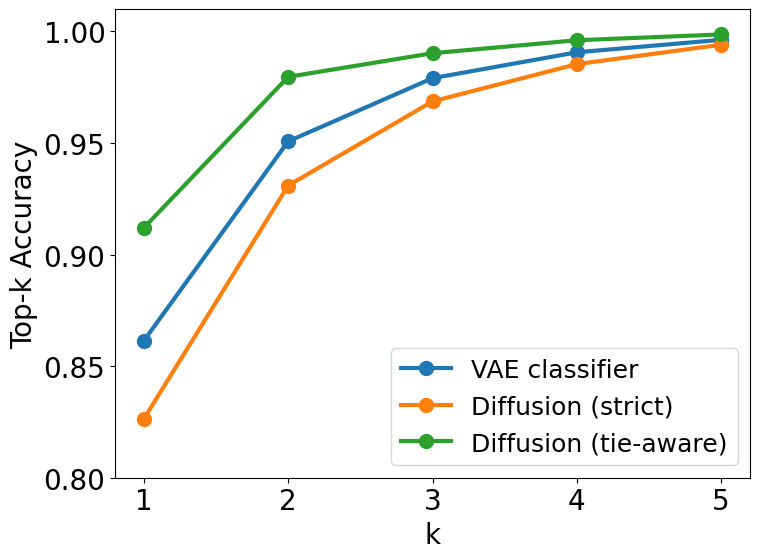

Saved: topk_accuracy_comparison.svg


In [11]:
# -------- Plot 2: Top-k accuracy vs k (VAE vs Diffusion strict vs Tie) ----

TOP_K_LIST = [1,2, 3,4, 5]
ks = np.array(TOP_K_LIST)
curve_vae = np.array([topk_accs_vae[k] for k in ks])
curve_diff_strict = np.array([strict_accs_diff[k] for k in ks])
curve_diff_tie = np.array([tie_accs_diff[k] for k in ks])

plt.figure(figsize=(8,6))
plt.plot(ks, curve_vae, marker='o', lw=3,ms = 10, label='VAE classifier')
plt.plot(ks, curve_diff_strict, marker='o',ms = 10, lw=3, label='Diffusion (strict)')
plt.plot(ks, curve_diff_tie, marker='o',ms = 10, lw=3, label='Diffusion (tie-aware)')
plt.xlabel("k")
plt.ylabel("Top-k Accuracy")
plt.ylim(0.8, 1.01)
plt.legend()
plt.tight_layout()
plt.savefig("topk_accuracy_comparison.svg", format="svg", bbox_inches="tight")
plt.show()
print("Saved: topk_accuracy_comparison.svg")
